## Compare models

### Basic Parameter

In [1]:
Input_Dir  = 'data_raw_all'
Output_Dir = 'models'
Save_Evaluation_Images = False

Input_Shape = (32,32,3)

# Validation size
# Note: 0.0 = 0% validation size, use all images for training
Validation_Percentage = 0.2

In [2]:
# Parameters
Input_Dir = "data_raw_all"


### Load libraries and defaults

In [3]:
import os
import glob
from pathlib import Path
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image 

from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

2025-05-03 14:06:10.492747: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-03 14:06:10.495769: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-03 14:06:10.504164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746281170.517973   33411 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746281170.522179   33411 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-03 14:06:10.537681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Load files

In [4]:
files = glob.glob(Input_Dir + '/*.jpg')
y_data = np.empty((len(files)))
f_data = np.empty((len(files)), dtype="<U250")
x_data = np.empty((len(files),Input_Shape[0],Input_Shape[1],Input_Shape[2]))

for i, aktfile in enumerate(files):
    base = os.path.basename(aktfile)

    # get label from filename (1.2_ new or 1_ old),
    if (base[1]=="."):
        target = base[0:3]
    else:
        target = base[0:1]
    category = float(target)
    
    test_image = Image.open(aktfile).resize((Input_Shape[0],Input_Shape[1]), Image.Resampling.LANCZOS)
    test_image = np.array(test_image, dtype="float32")
    f_data[i] =  aktfile
    x_data[i] = test_image
    y_data[i] =  category
print("Data count: ", len(y_data))  
print(x_data.shape)

x_data, y_data, f_data = shuffle(x_data, y_data, f_data)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Validation_Percentage)
y_train = keras.utils.to_categorical(y_train*10, 100)
y_test = keras.utils.to_categorical(y_test*10, 100)

print(np.expand_dims(y_data, axis=1).shape)

Data count:  1739
(1739, 32, 32, 3)
(1739, 1)


### Helper functions

In [5]:
def plot_dataset(images, labels, columns=10, rows=5, figsize=(18, 10)):

    fig = plt.figure(figsize=figsize)
    
    for i in range(1, columns*rows +1):
        if (i>len(labels)):
            break
        fig.add_subplot(rows, columns, i)
        plt.title(labels[i-1])  # set title
        plt.imshow((images[i-1]).astype(np.uint8), aspect='1', extent=[0, 1, 0, 1])
        # yellow lines
        ax=plt.gca()
        ax.get_yaxis().set_visible(False) 
        ax.get_xaxis().set_visible(False) 
        
        plt.tight_layout()
    plt.show()


def plot_divergence(divergationset, title1, nb_classes, filename=None):
    fig = plt.figure(figsize=(40, 10))
    fig.suptitle(title1, fontsize=28)
    plt.bar(np.arange (0, nb_classes/10, 0.1), divergationset, width=0.09, align='center')
    plt.ylabel('Count')
    plt.xlabel('Deviation')
    plt.xticks(np.arange(0, nb_classes/10, 0.1))
    plt.show()
    
    # Save plot
    if filename:
        fig.savefig(filename, bbox_inches='tight')
    
    return fig


def evaluate_ziffer_tflite(model_path, x_data, y_data, f_data, title, max_delta = 0.11, save_images=False):
    false_images = []
    false_labels = []
    false_predicted = []

    # we use the tflite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    # ignore models with other shape than 32,32,3
    if ((interpreter.get_input_details()[0]["shape"] != (1, 32, 32, 3)).any()):
        return


    for x, y, f in zip(x_data, y_data, f_data):
        
        interpreter.set_tensor(input_index, np.expand_dims(x.astype(np.float32), axis=0))
        # Run inference.
        interpreter.invoke()
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.get_tensor(output_index)
        if (len(output[0])==2):
            out_sin = output[0][0]  
            out_cos = output[0][1]
            prediction = np.round(((np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1)*10,1)
        else:
            prediction = (np.argmax(output, axis=1).reshape(-1)/10)[0]

        difference = min(abs(prediction-y), abs(prediction-(10-y)))
        #print(prediction, y, difference)
        if difference > max_delta:
            false_images.append(x)
            false_labels.append( "Expected: " + str(y) + "\n Predicted: " + str(prediction) + "\n" + str(f)[-28:-5])
            false_predicted.append(difference)
    
    accuracy = "{:.2f}%".format((1-len(false_labels)/len(y_data))*100)
    title = f"Model: {os.path.basename(model_path)}  |  Images: {len(y_data)}\nAccuracy: {accuracy} (False Predicted: {len(false_labels)}) With Accepted Deviation: {max_delta}"
    
    if save_images:
        filename = os.path.join(Output_Dir, os.path.basename(model_path) + ".png")
    else:
        filename = None
        
    # plot the differences (max difference can only be 5.0)
    plot_divergence(np.bincount(np.array(np.array(false_predicted)*10).astype(int), minlength=51), title, 51, filename)

    # plot the false predicted images
    #plot_dataset(np.array(false_images), false_labels, columns=7, rows=7, figsize=(18,18))

### Evaluate Accuracy (Accepted Deviation: 0.11)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


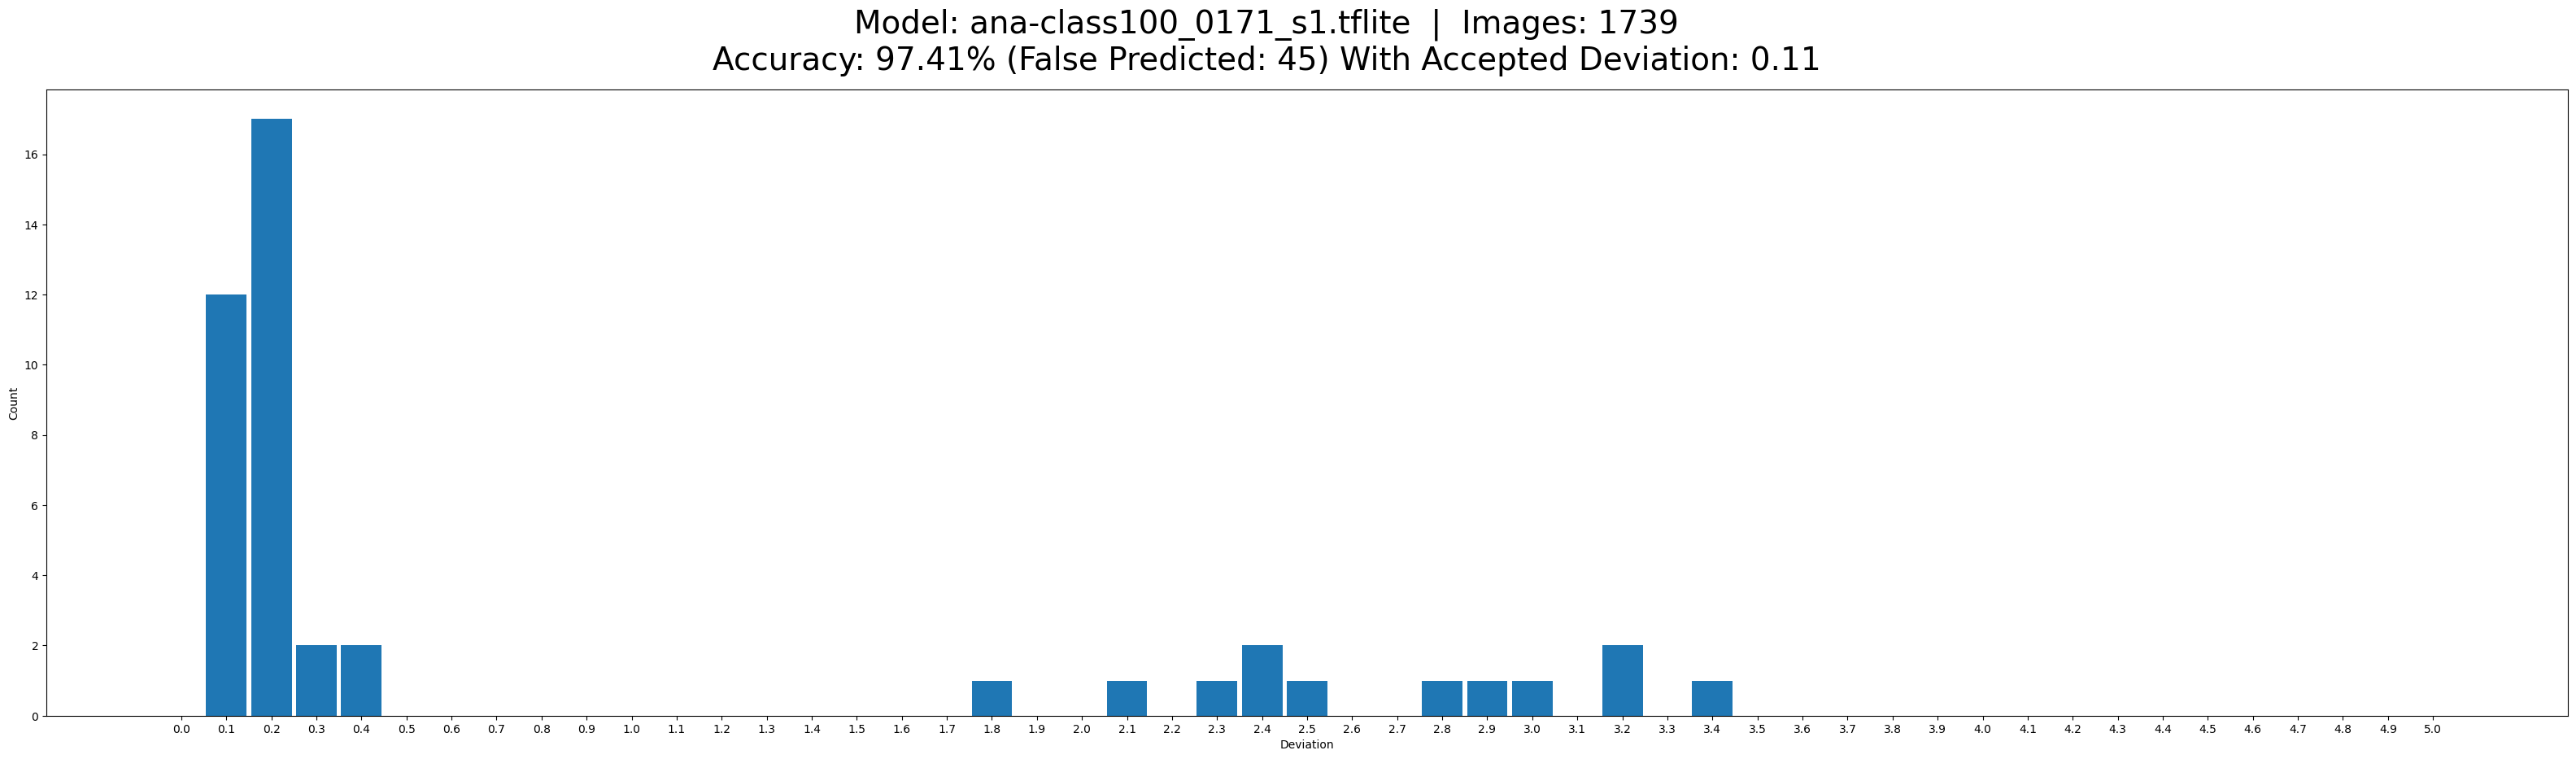

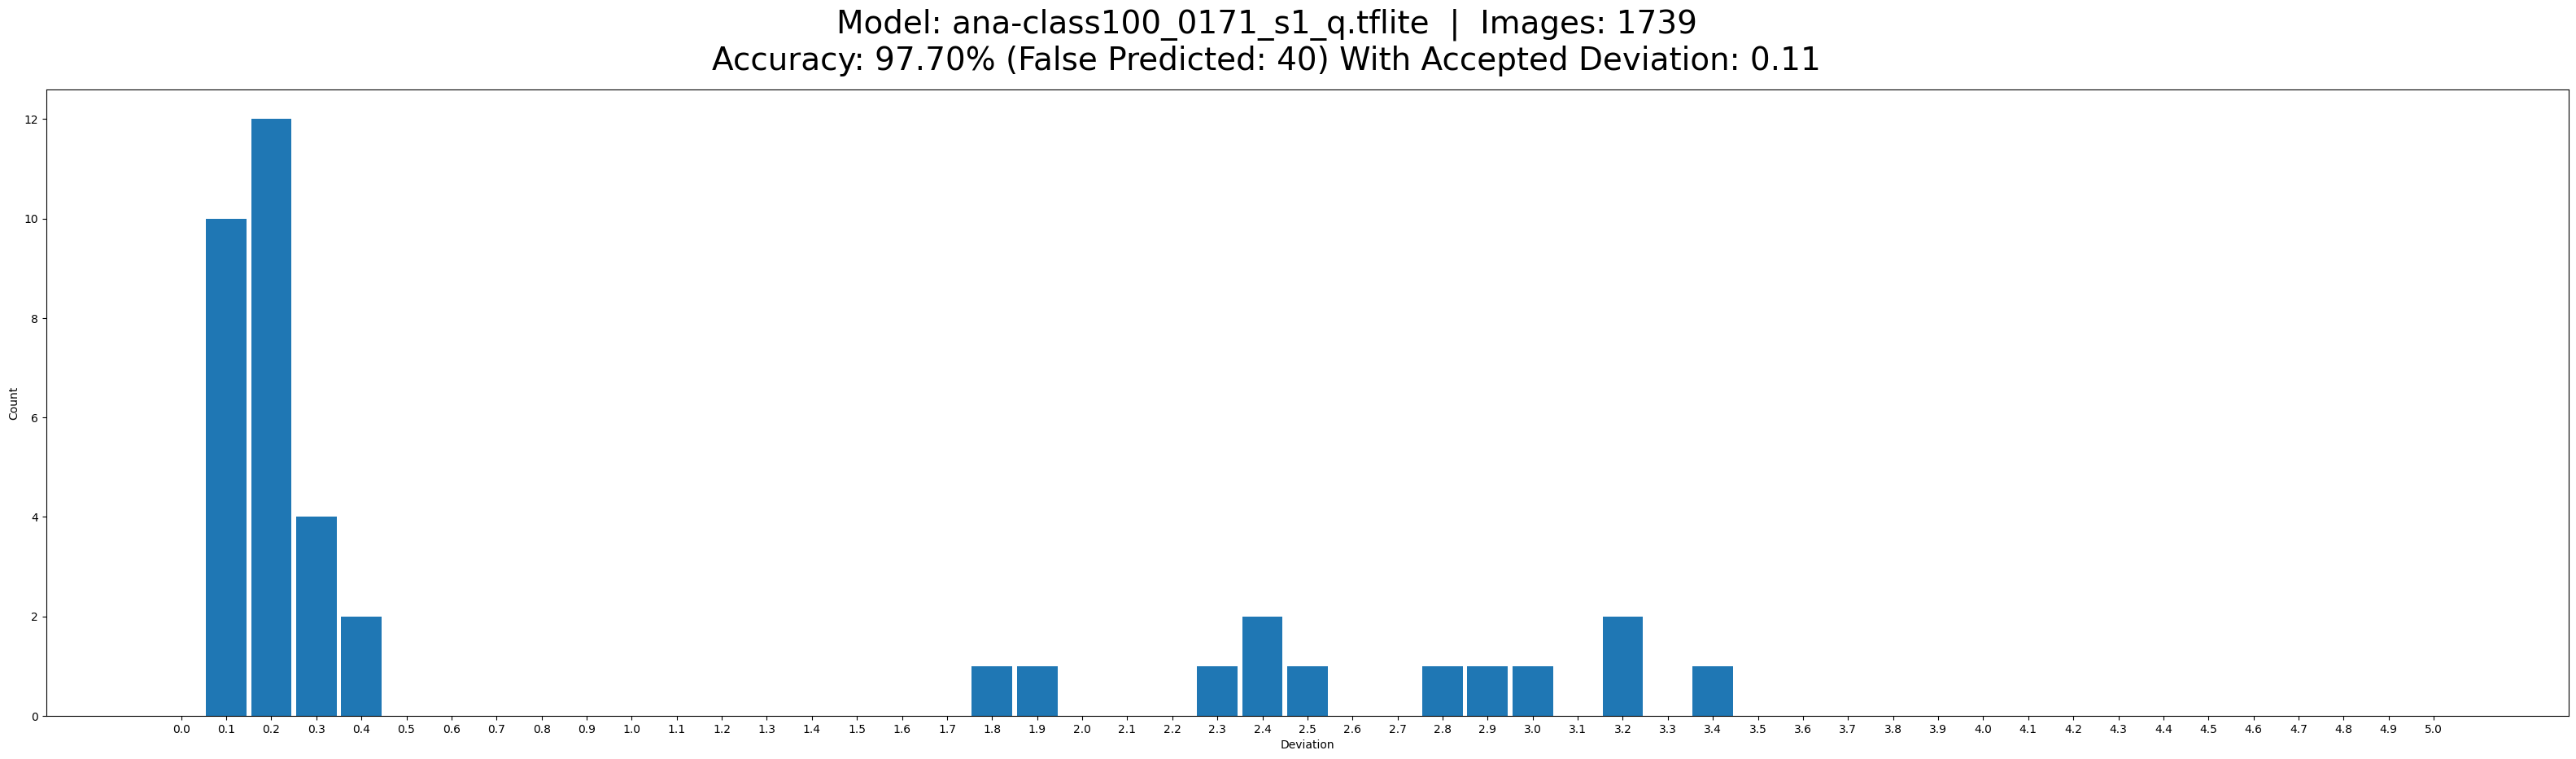

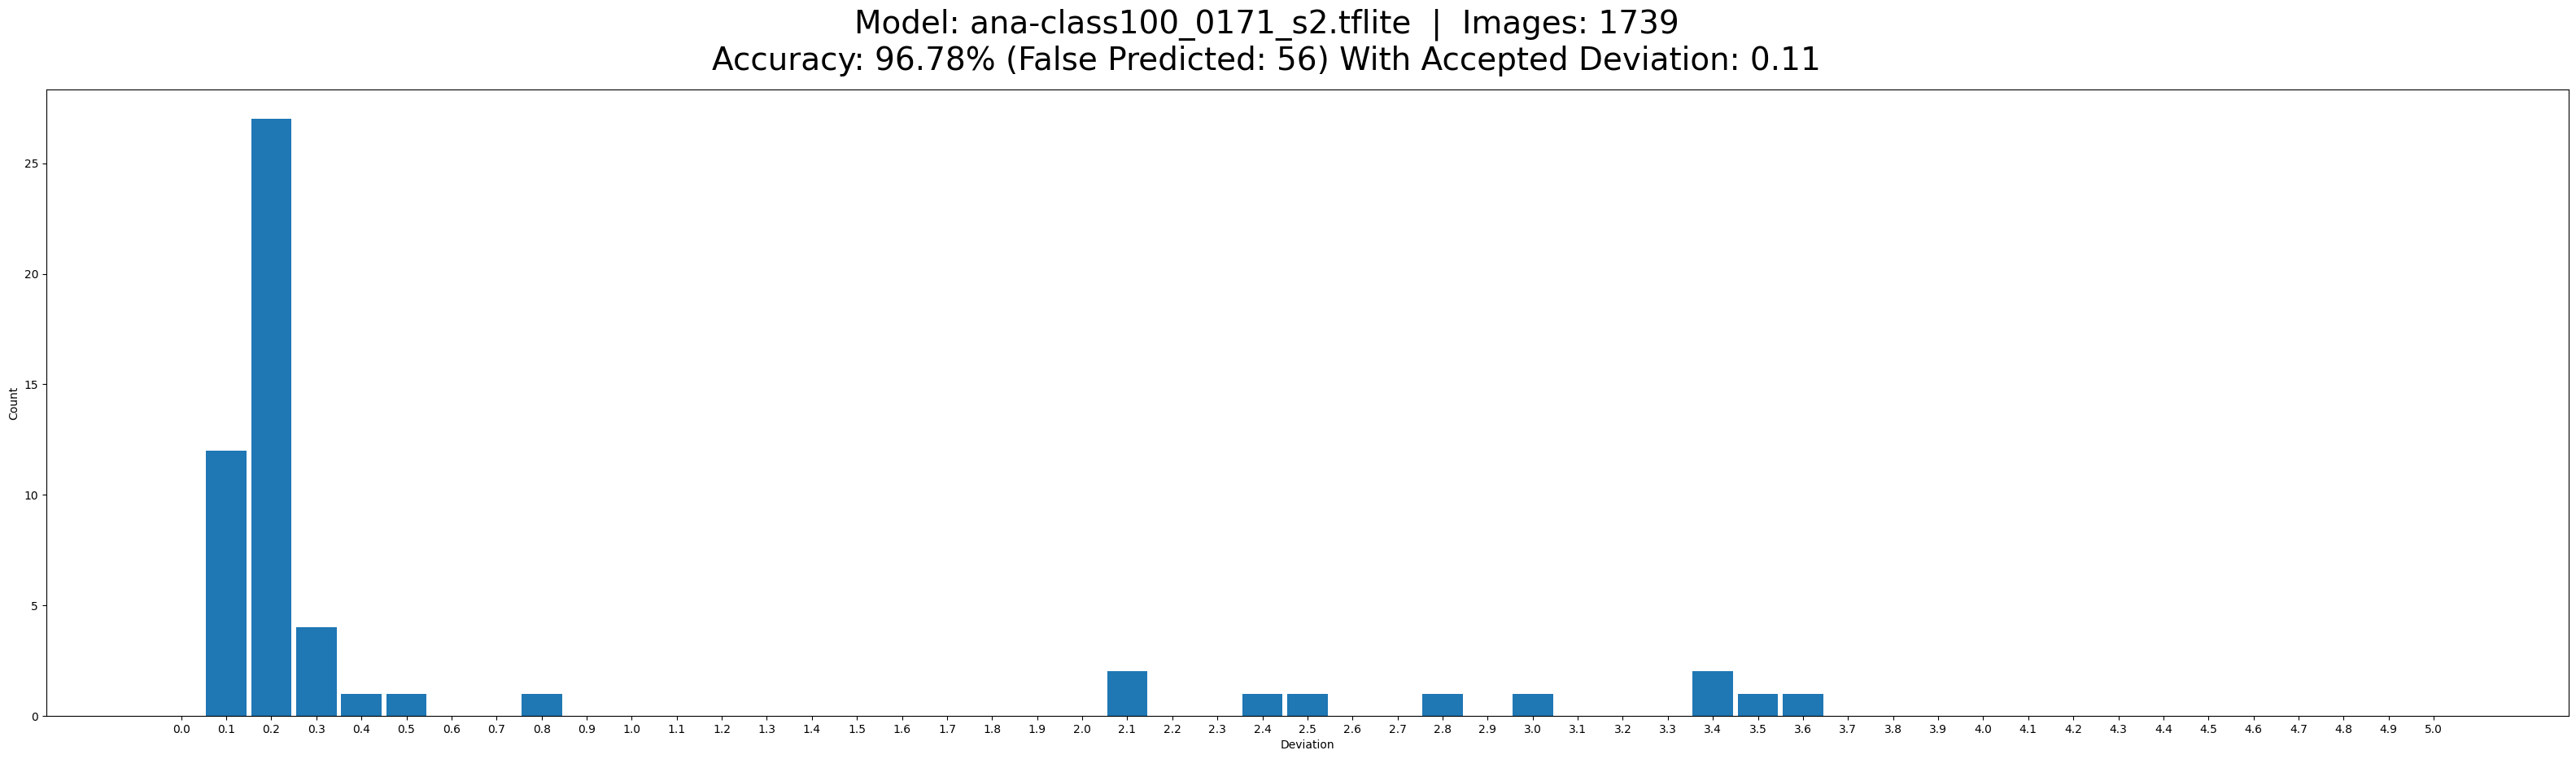

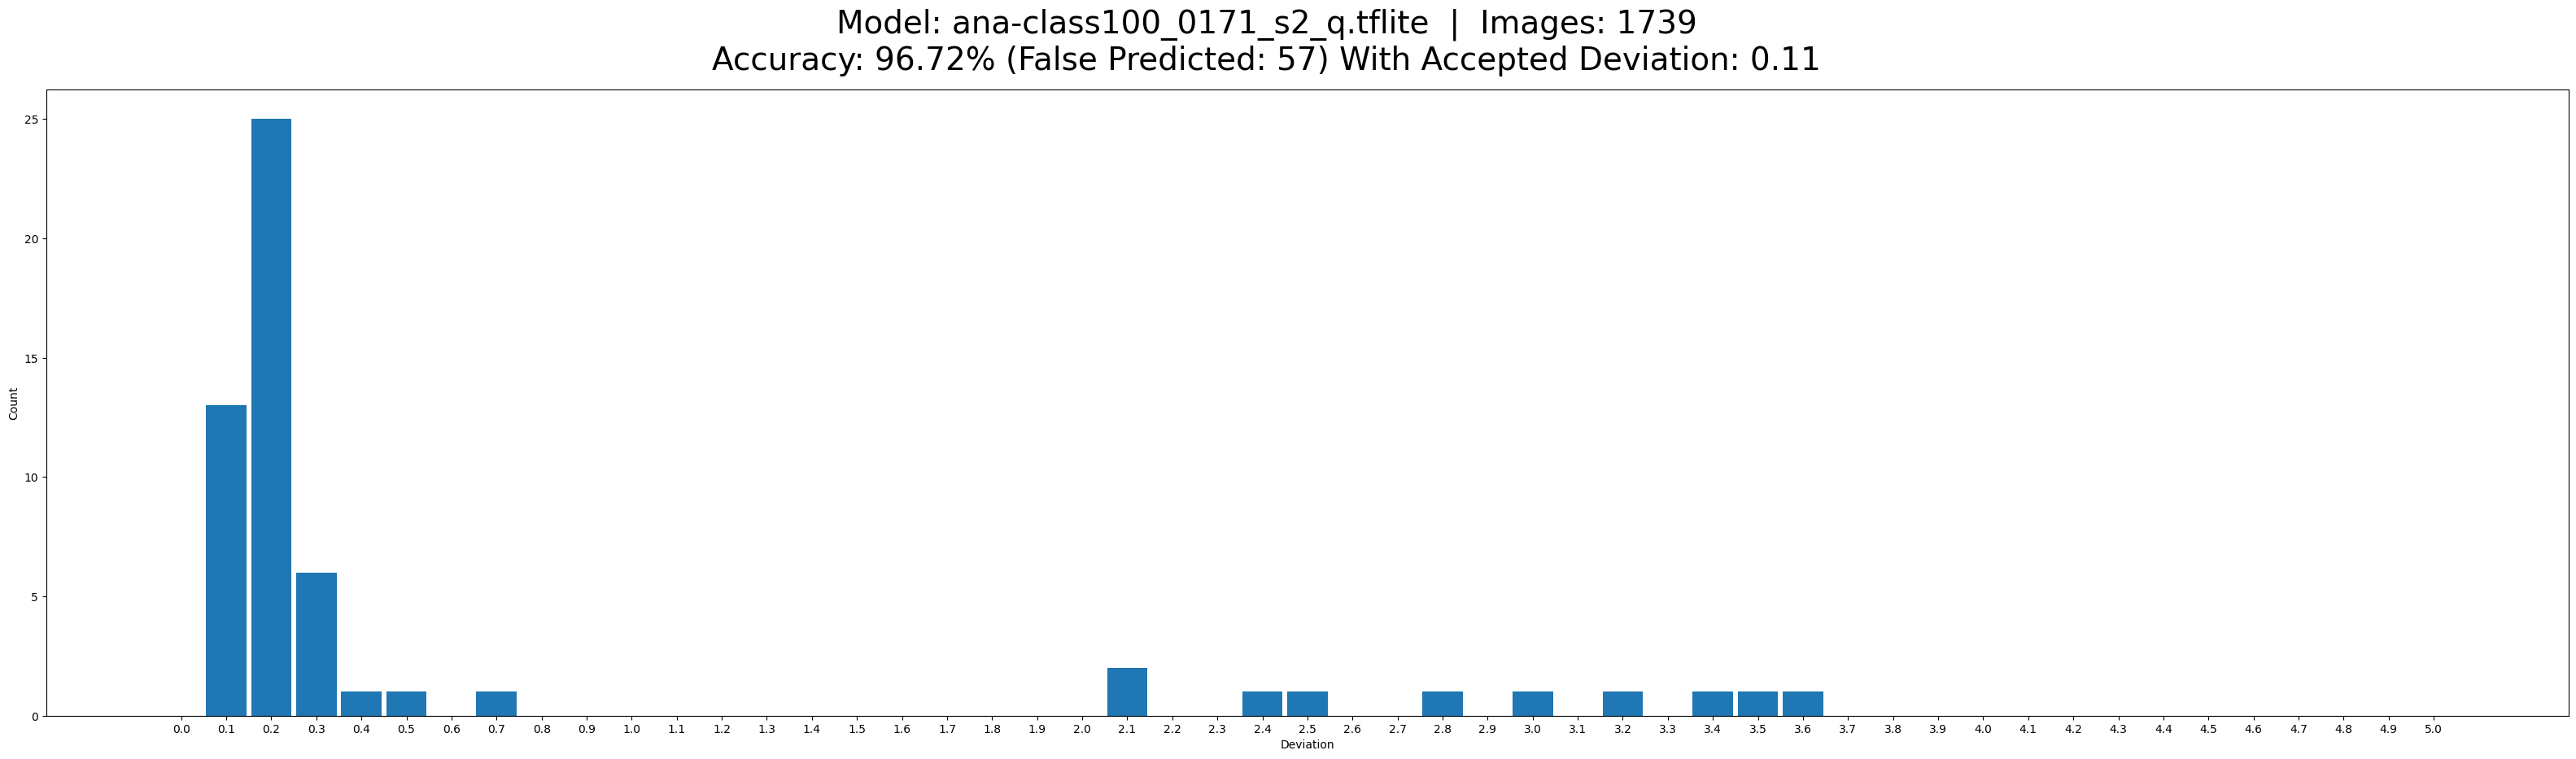

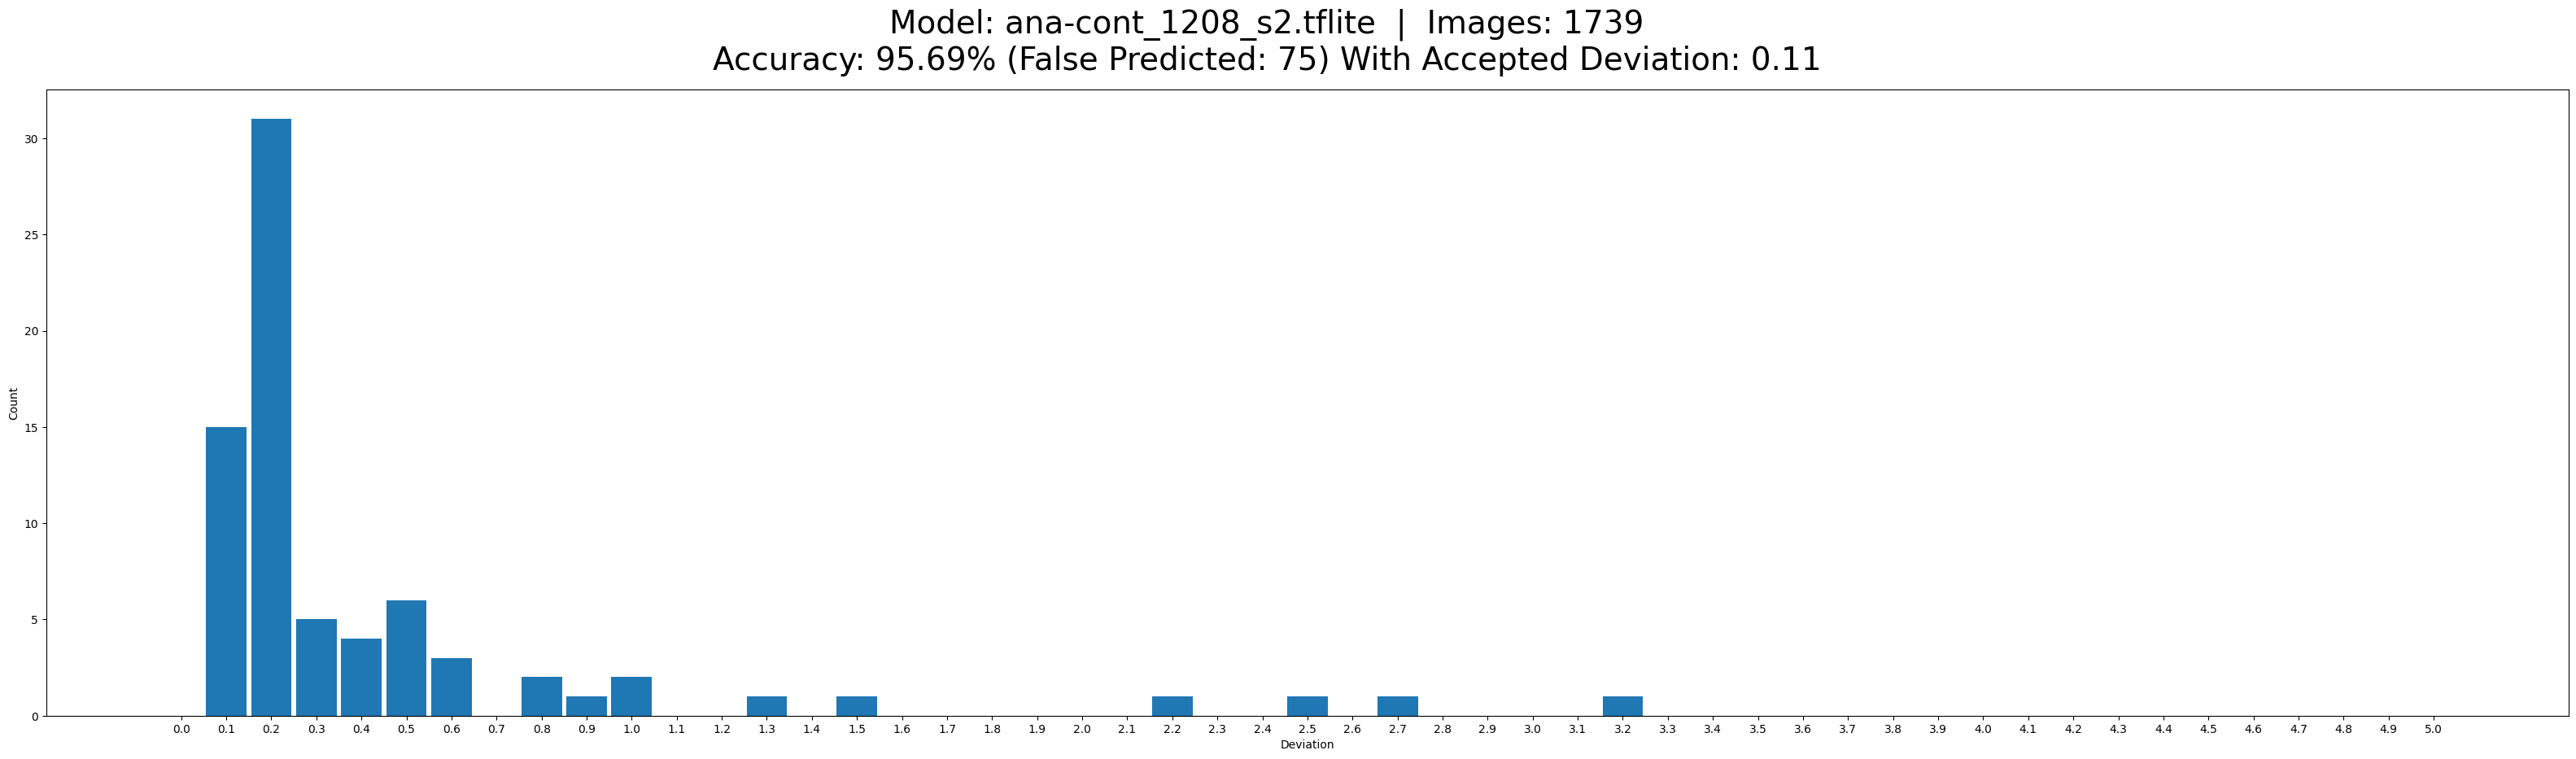

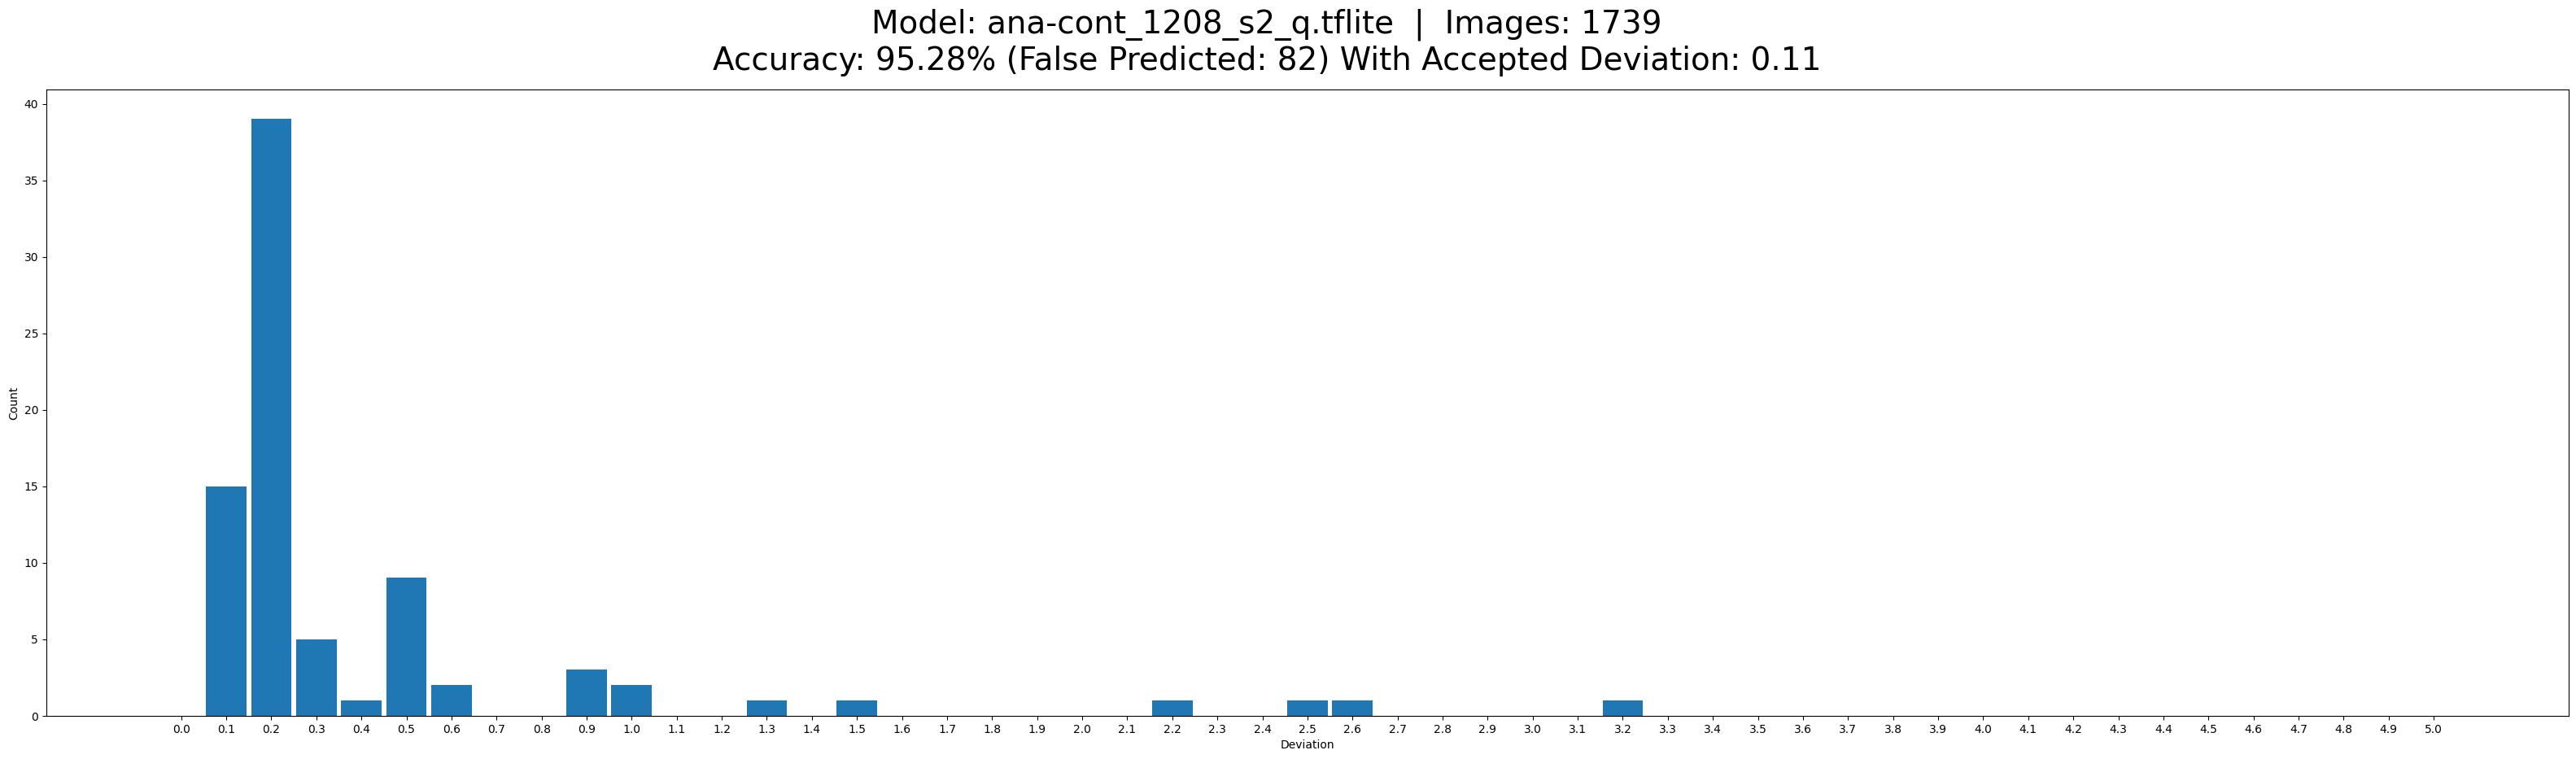

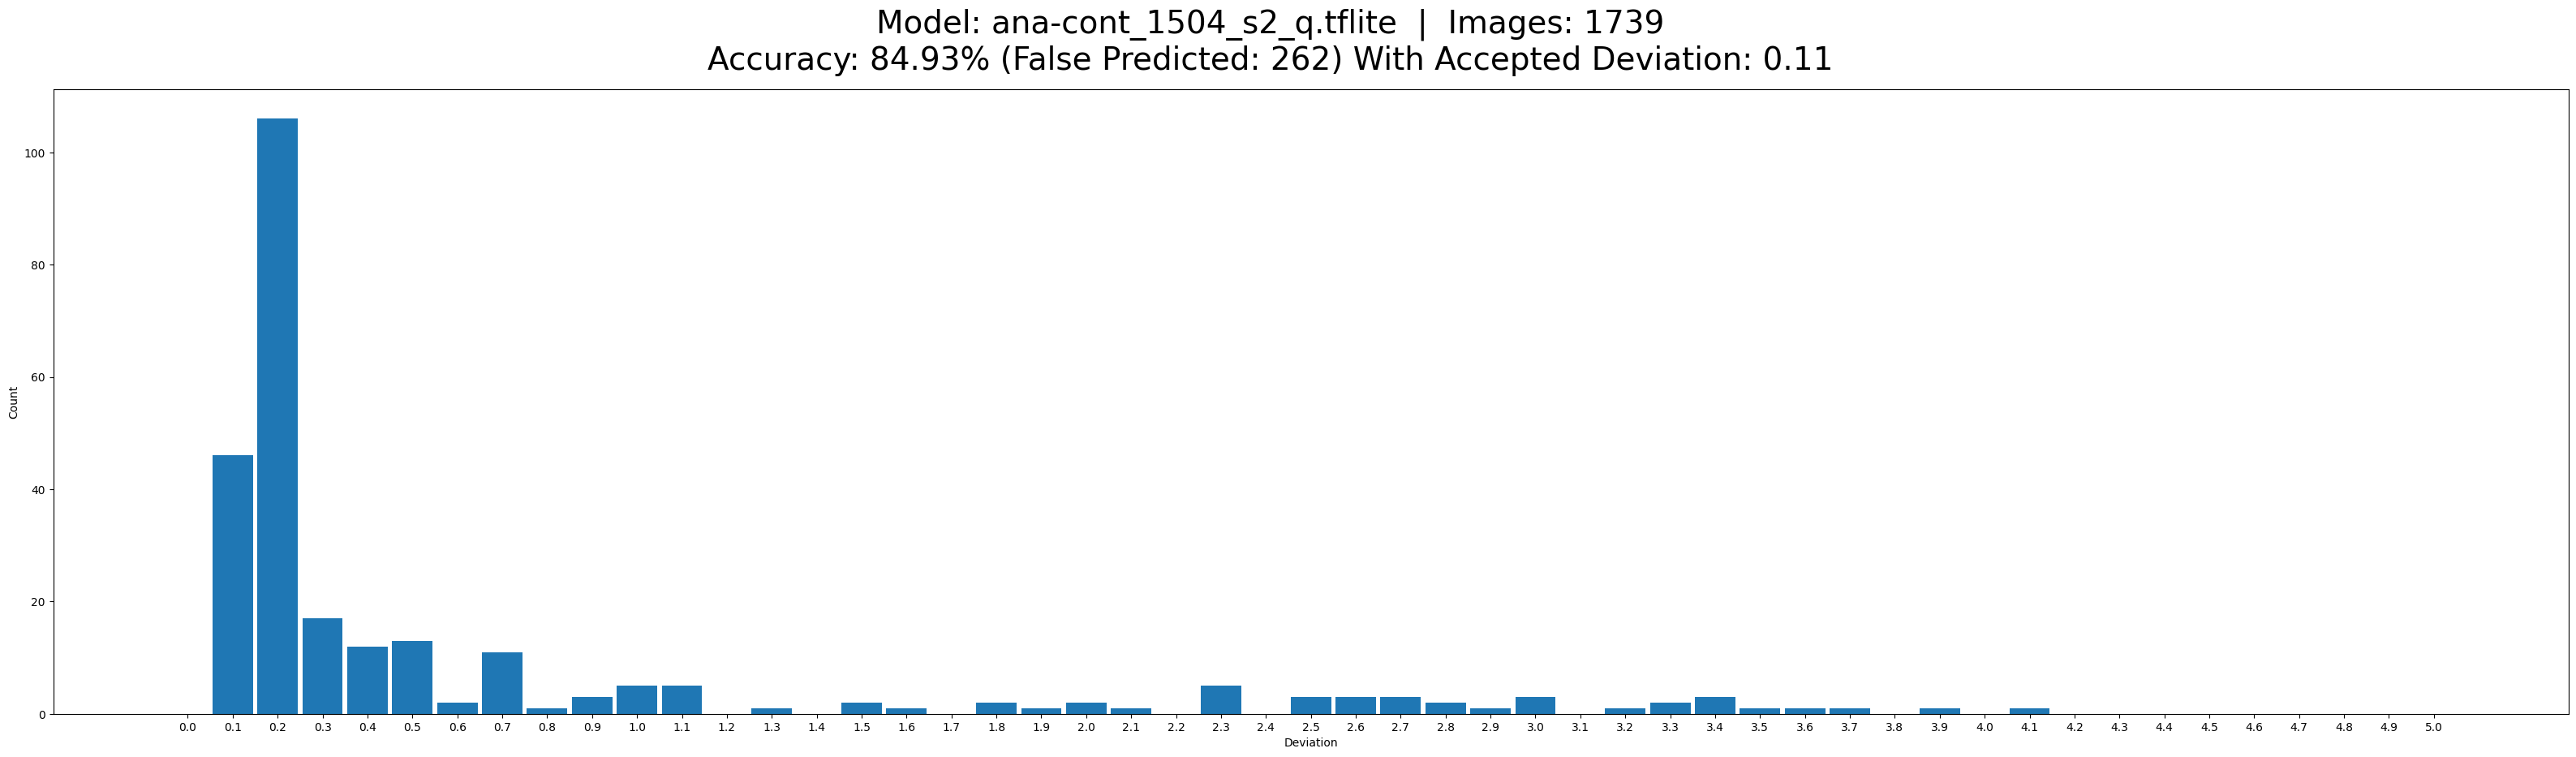

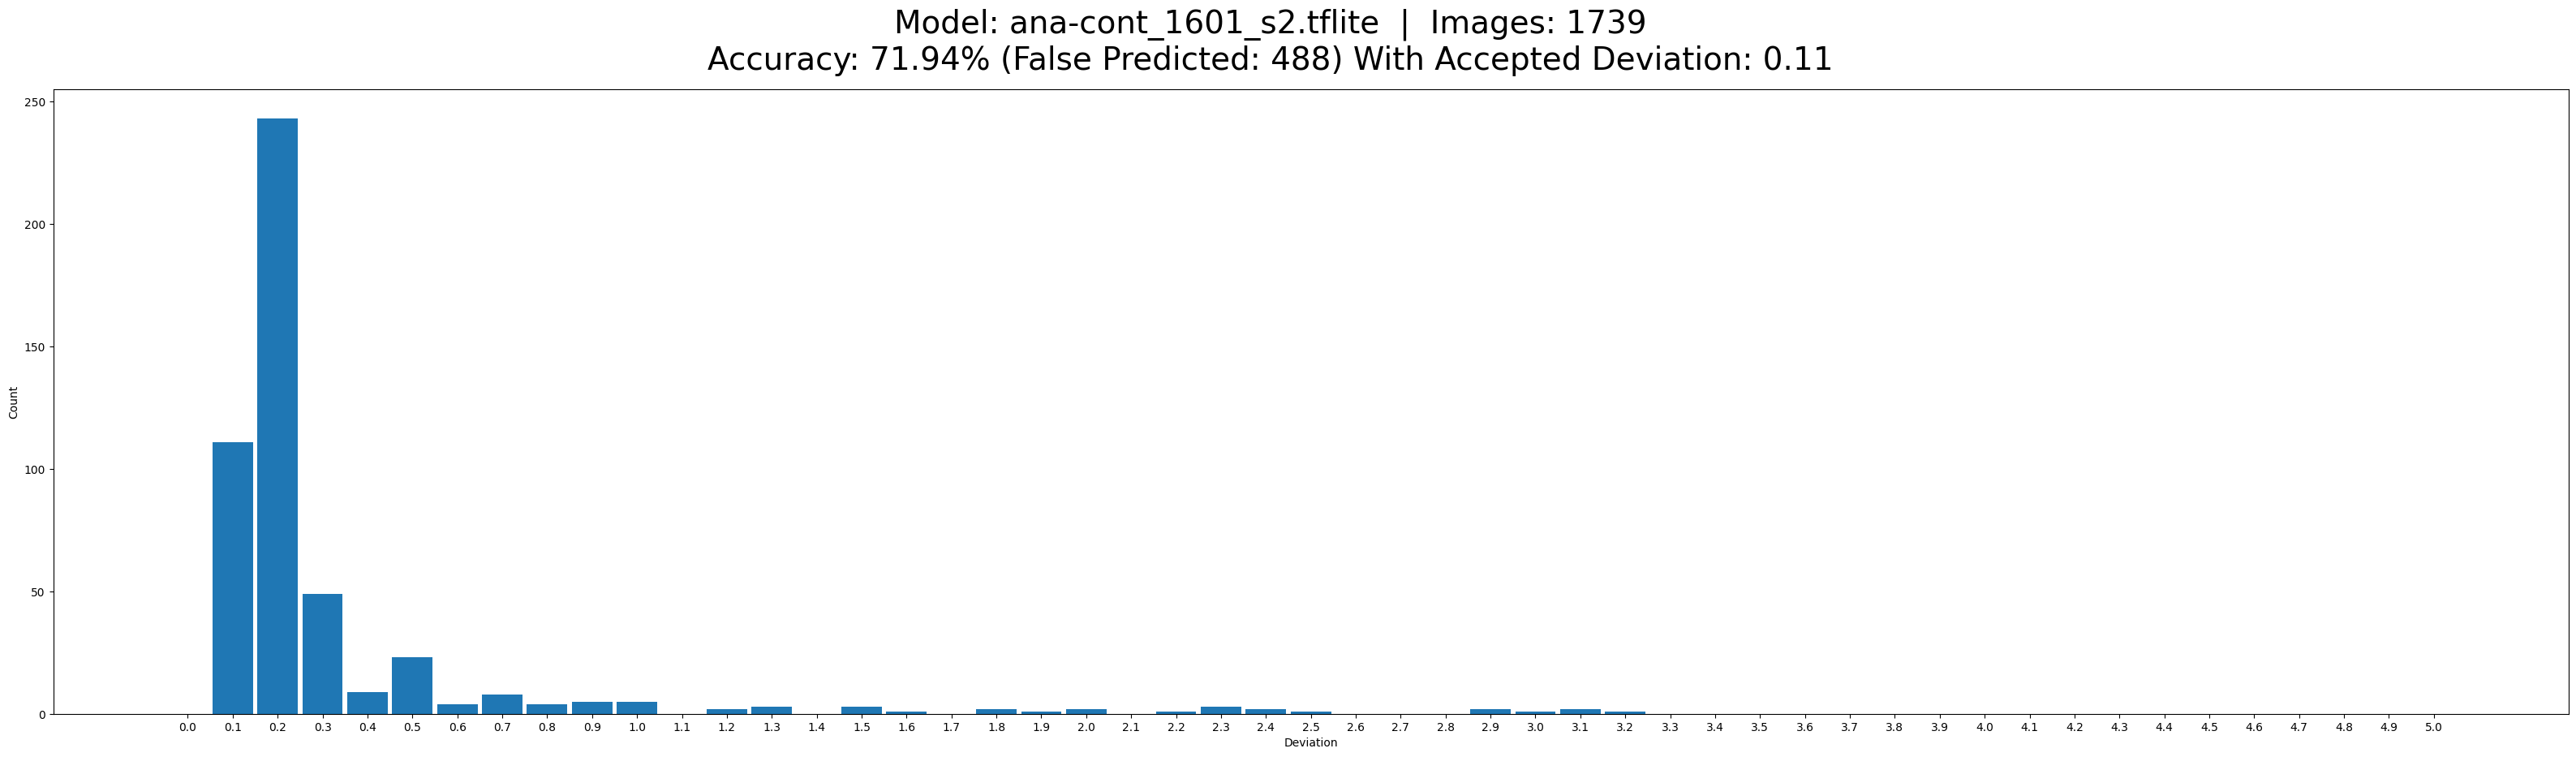

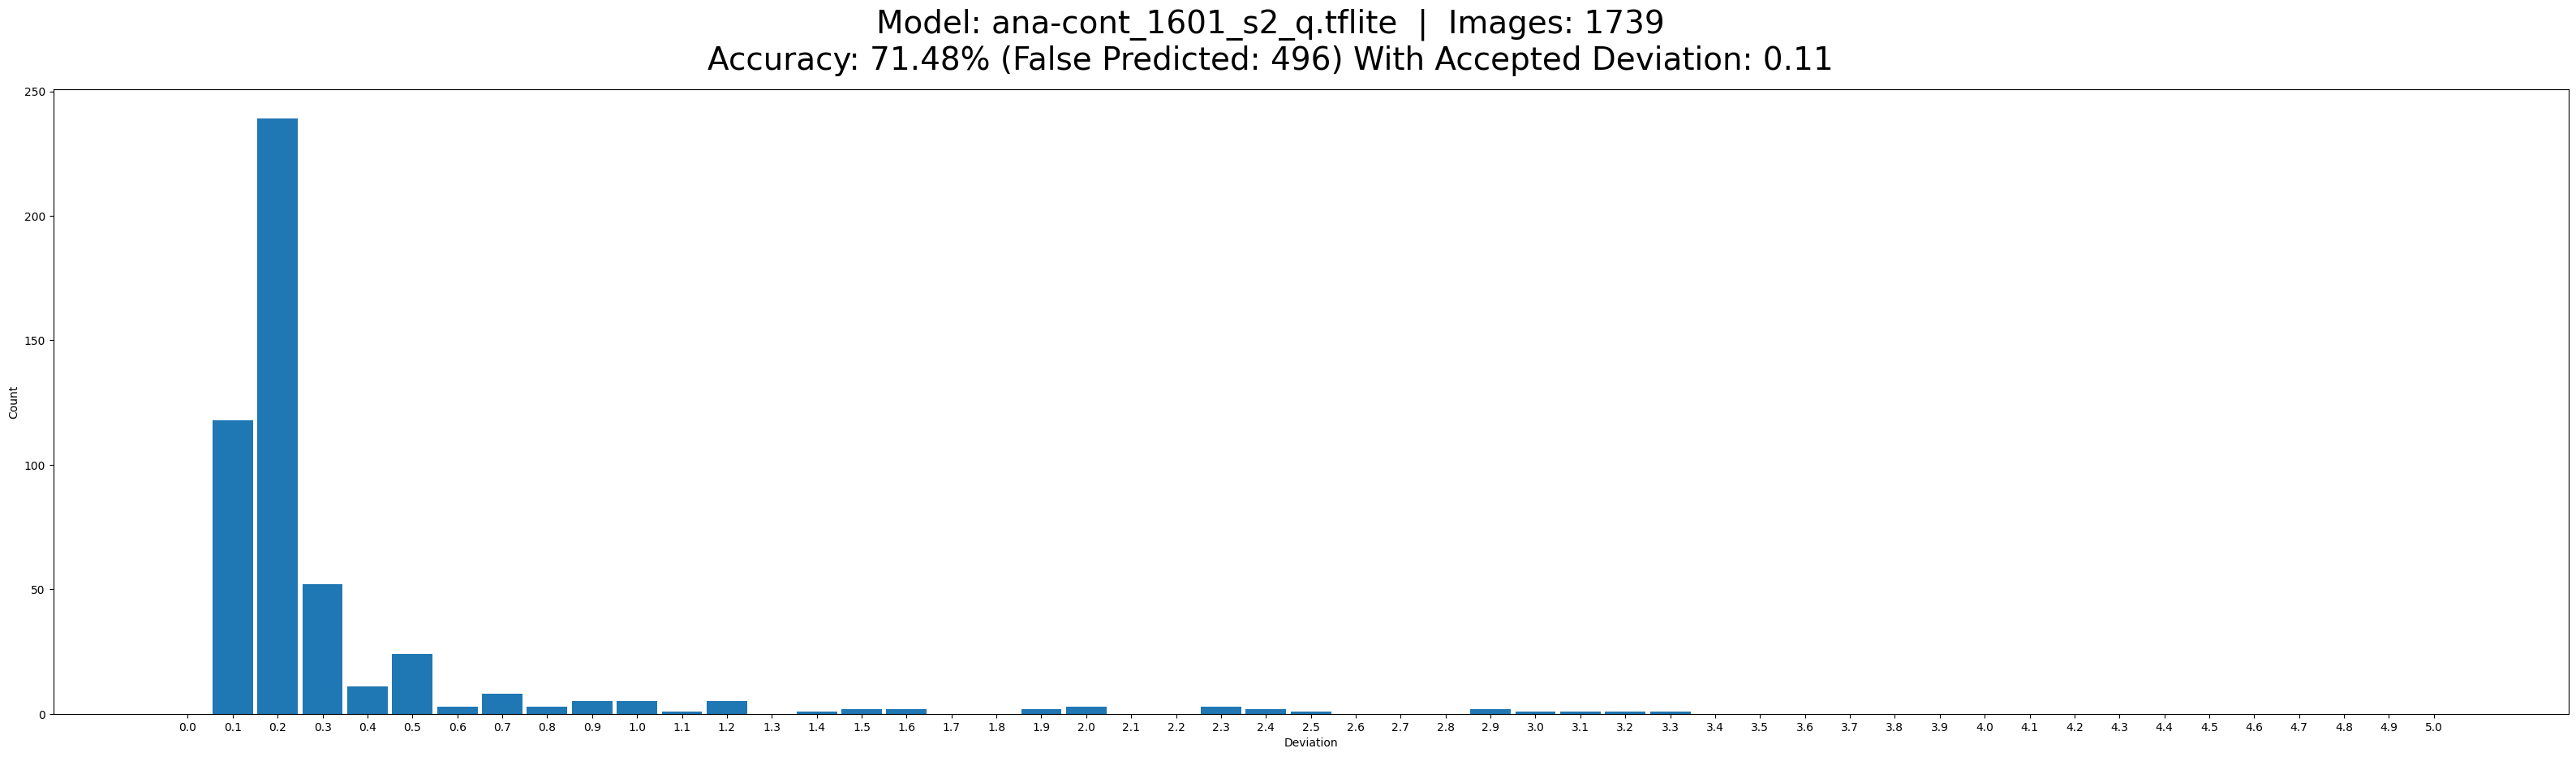

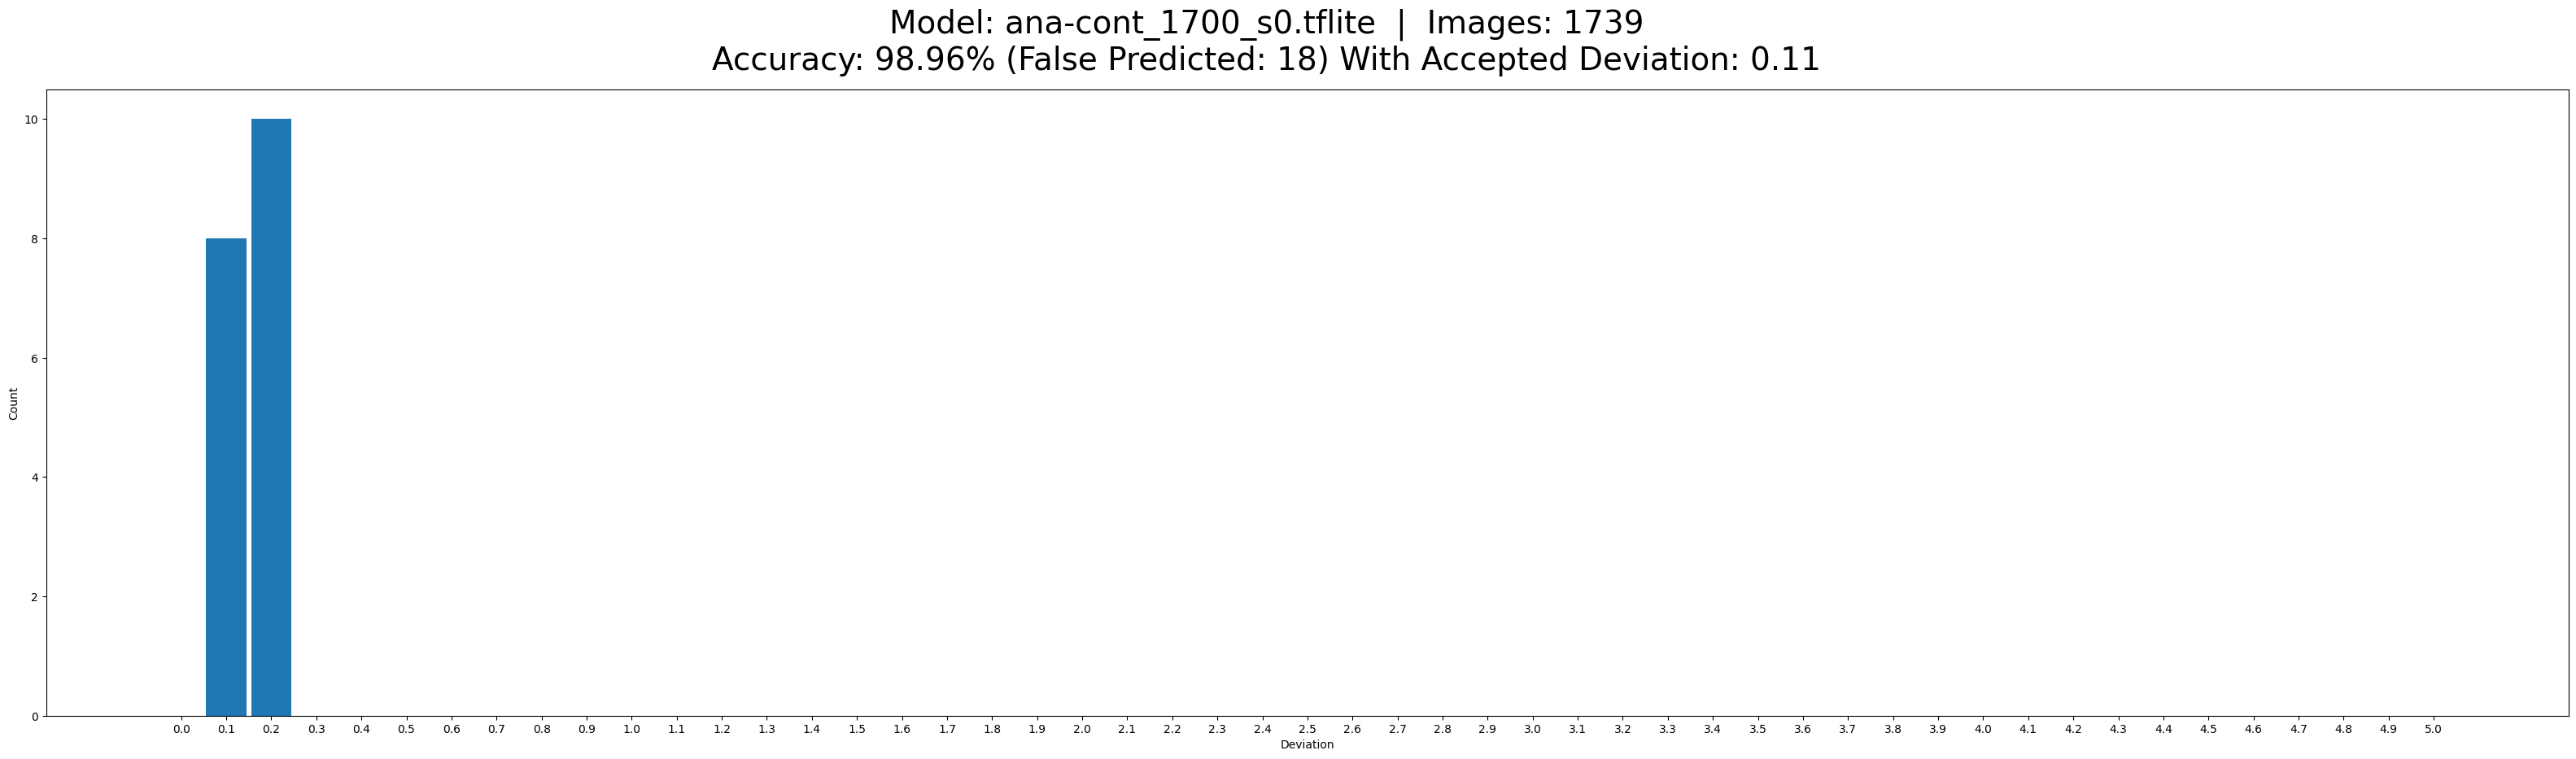

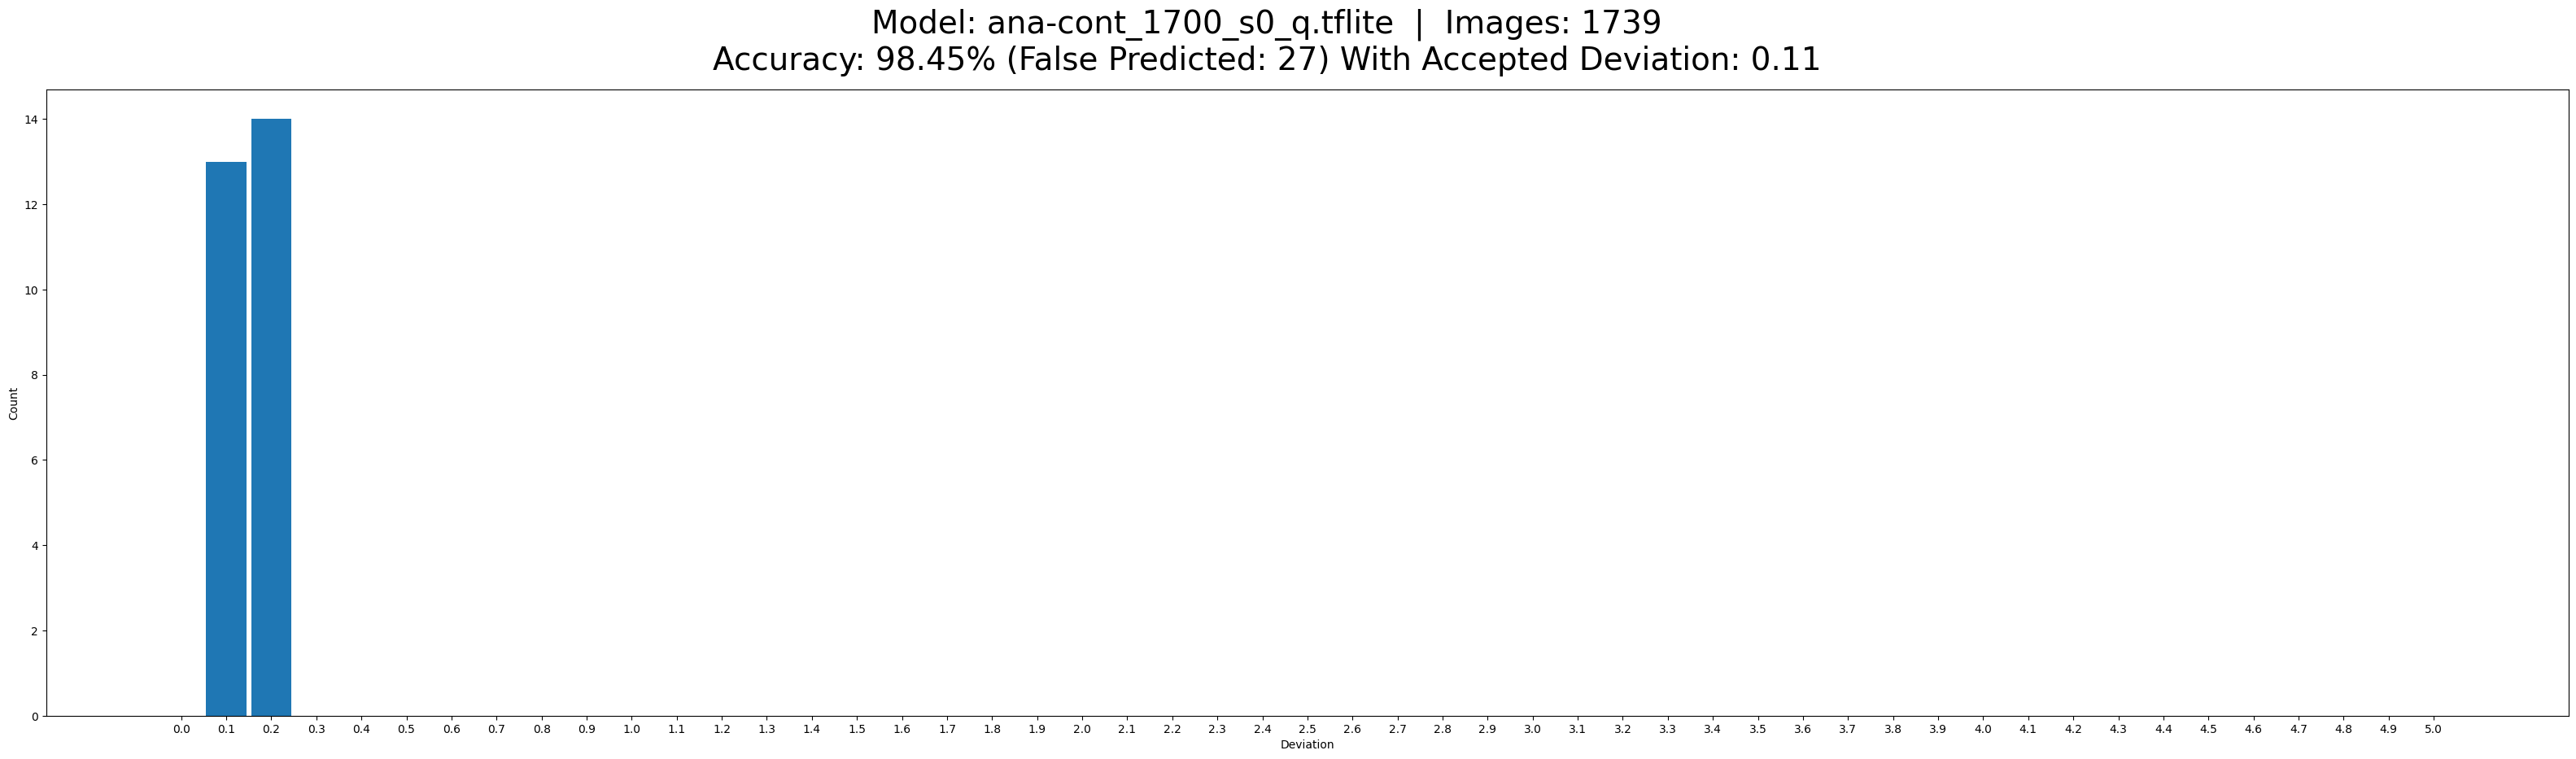

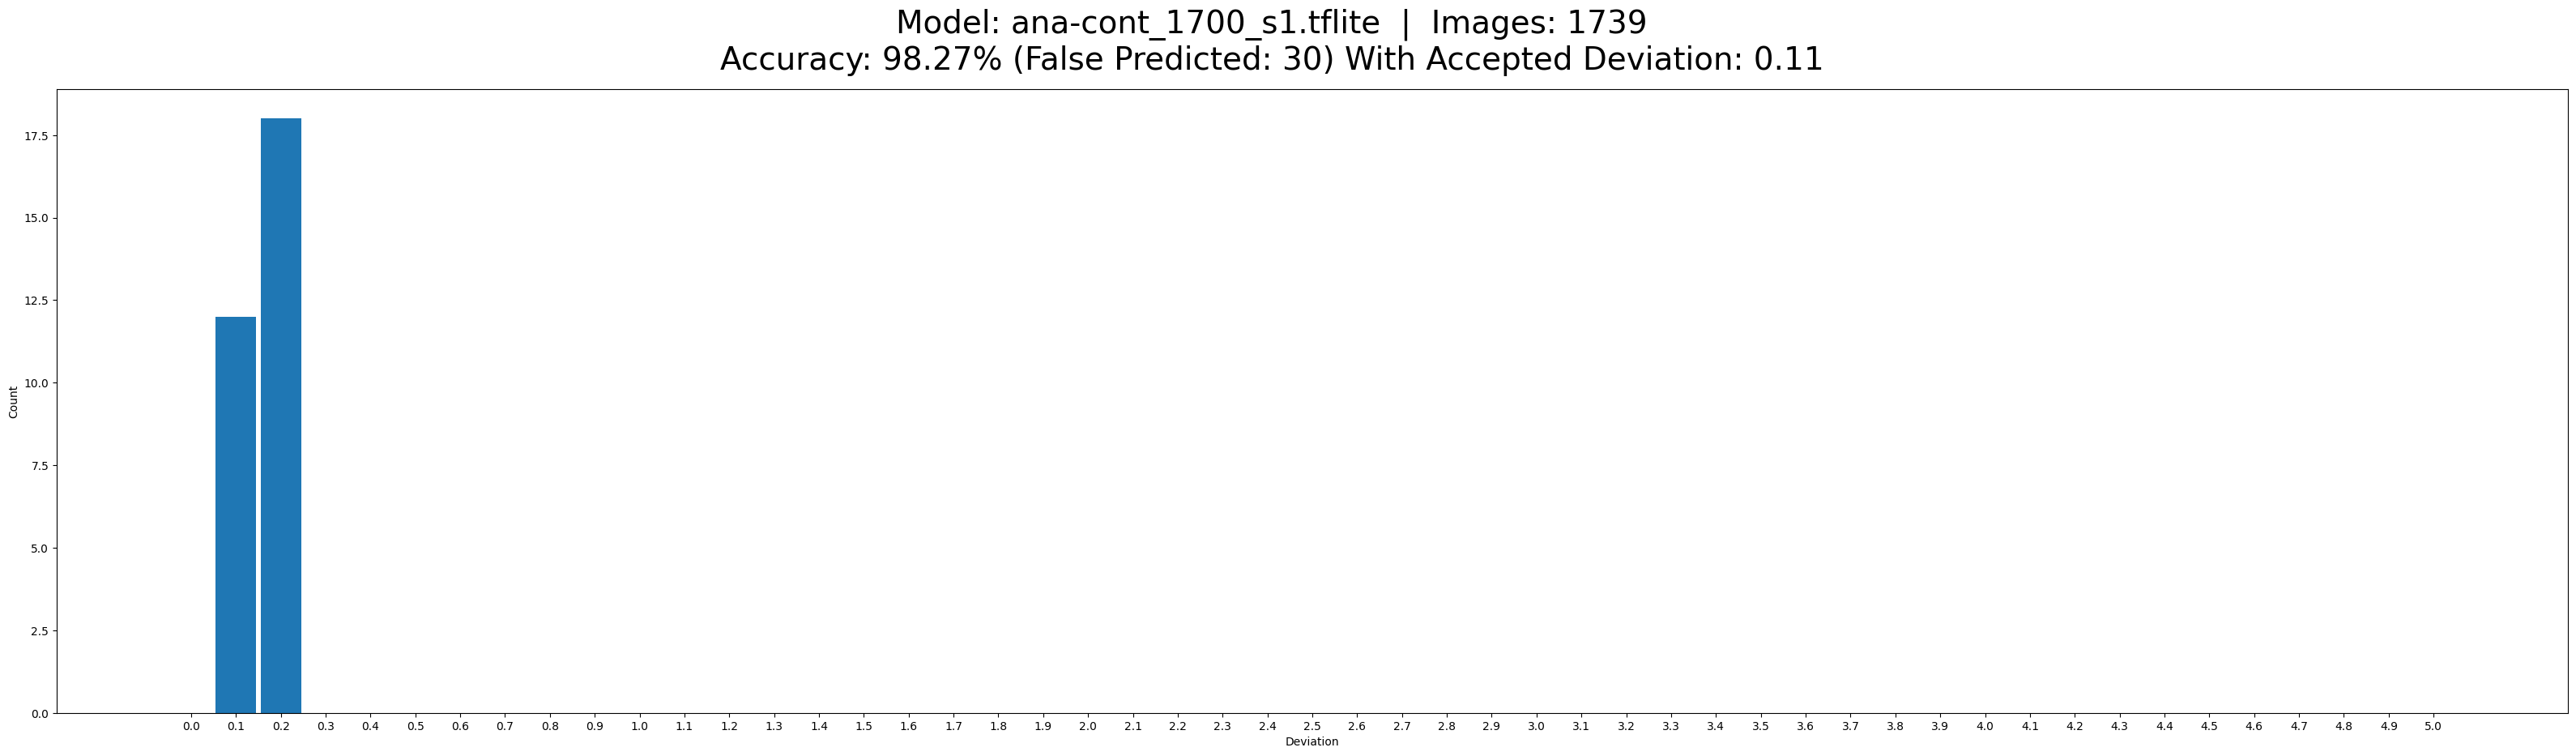

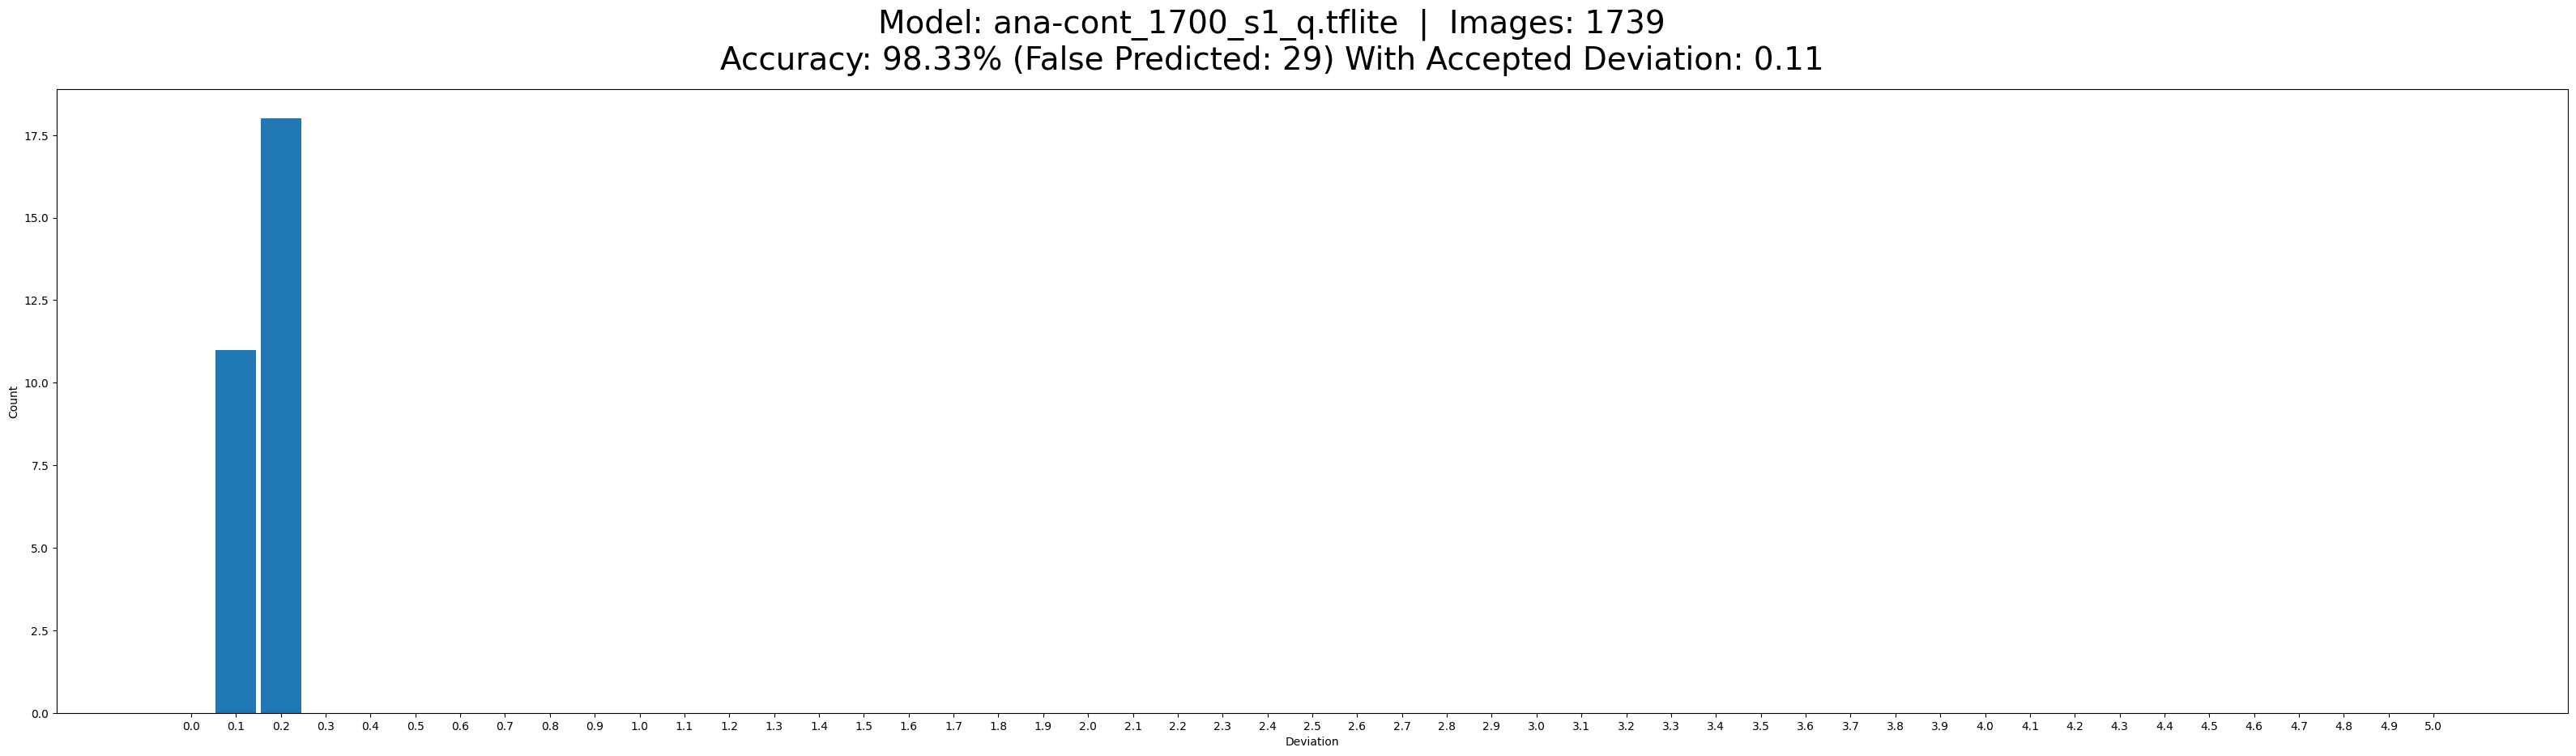

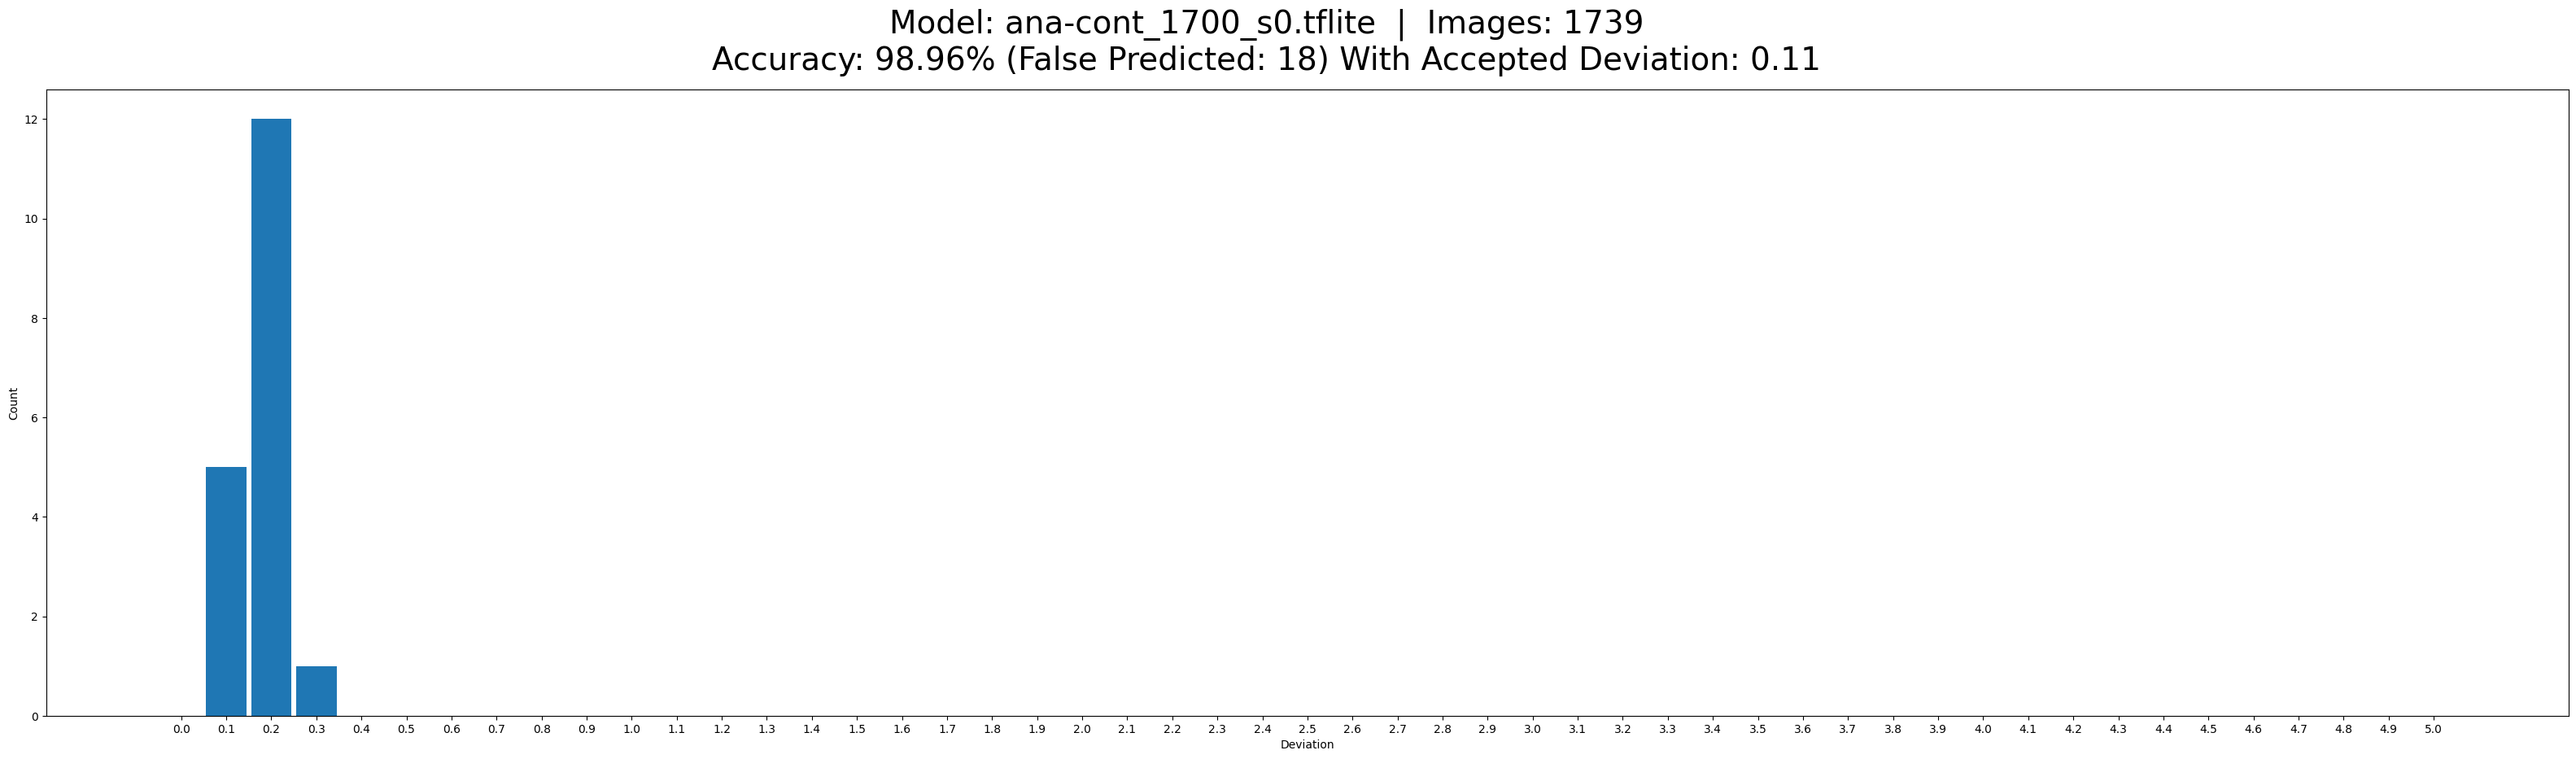

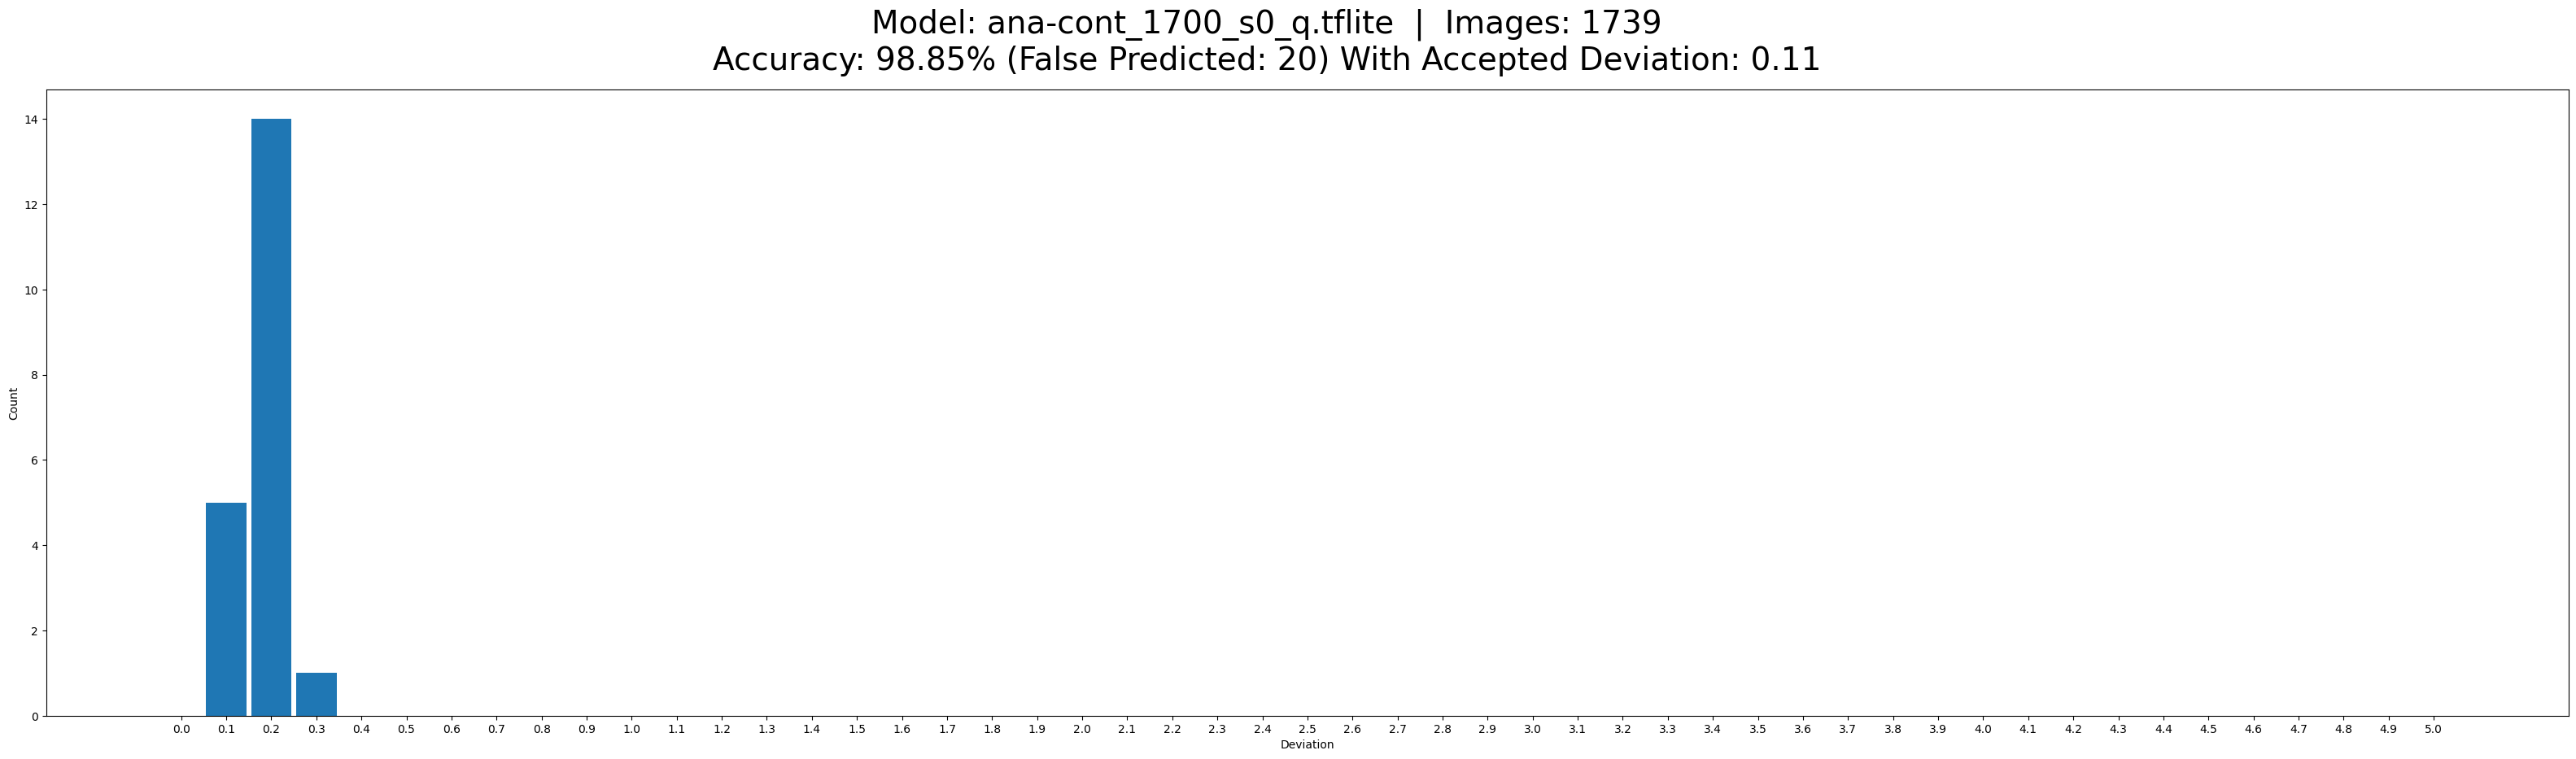

In [6]:
modelfiles = sorted(glob.glob('models/ana-class100/*.tflite')) + sorted(glob.glob('models/ana-cont/*.tflite')) + sorted(glob.glob('models_tmp/*.tflite'))

for modelfile in modelfiles:
    evaluate_ziffer_tflite(modelfile, x_data, y_data, f_data, title=modelfile, max_delta=0.11, save_images=Save_Evaluation_Images)
    print(f" ")
    print(f" ")
    

### Evaluate Accuracy (Accepted Deviation: 0.01)

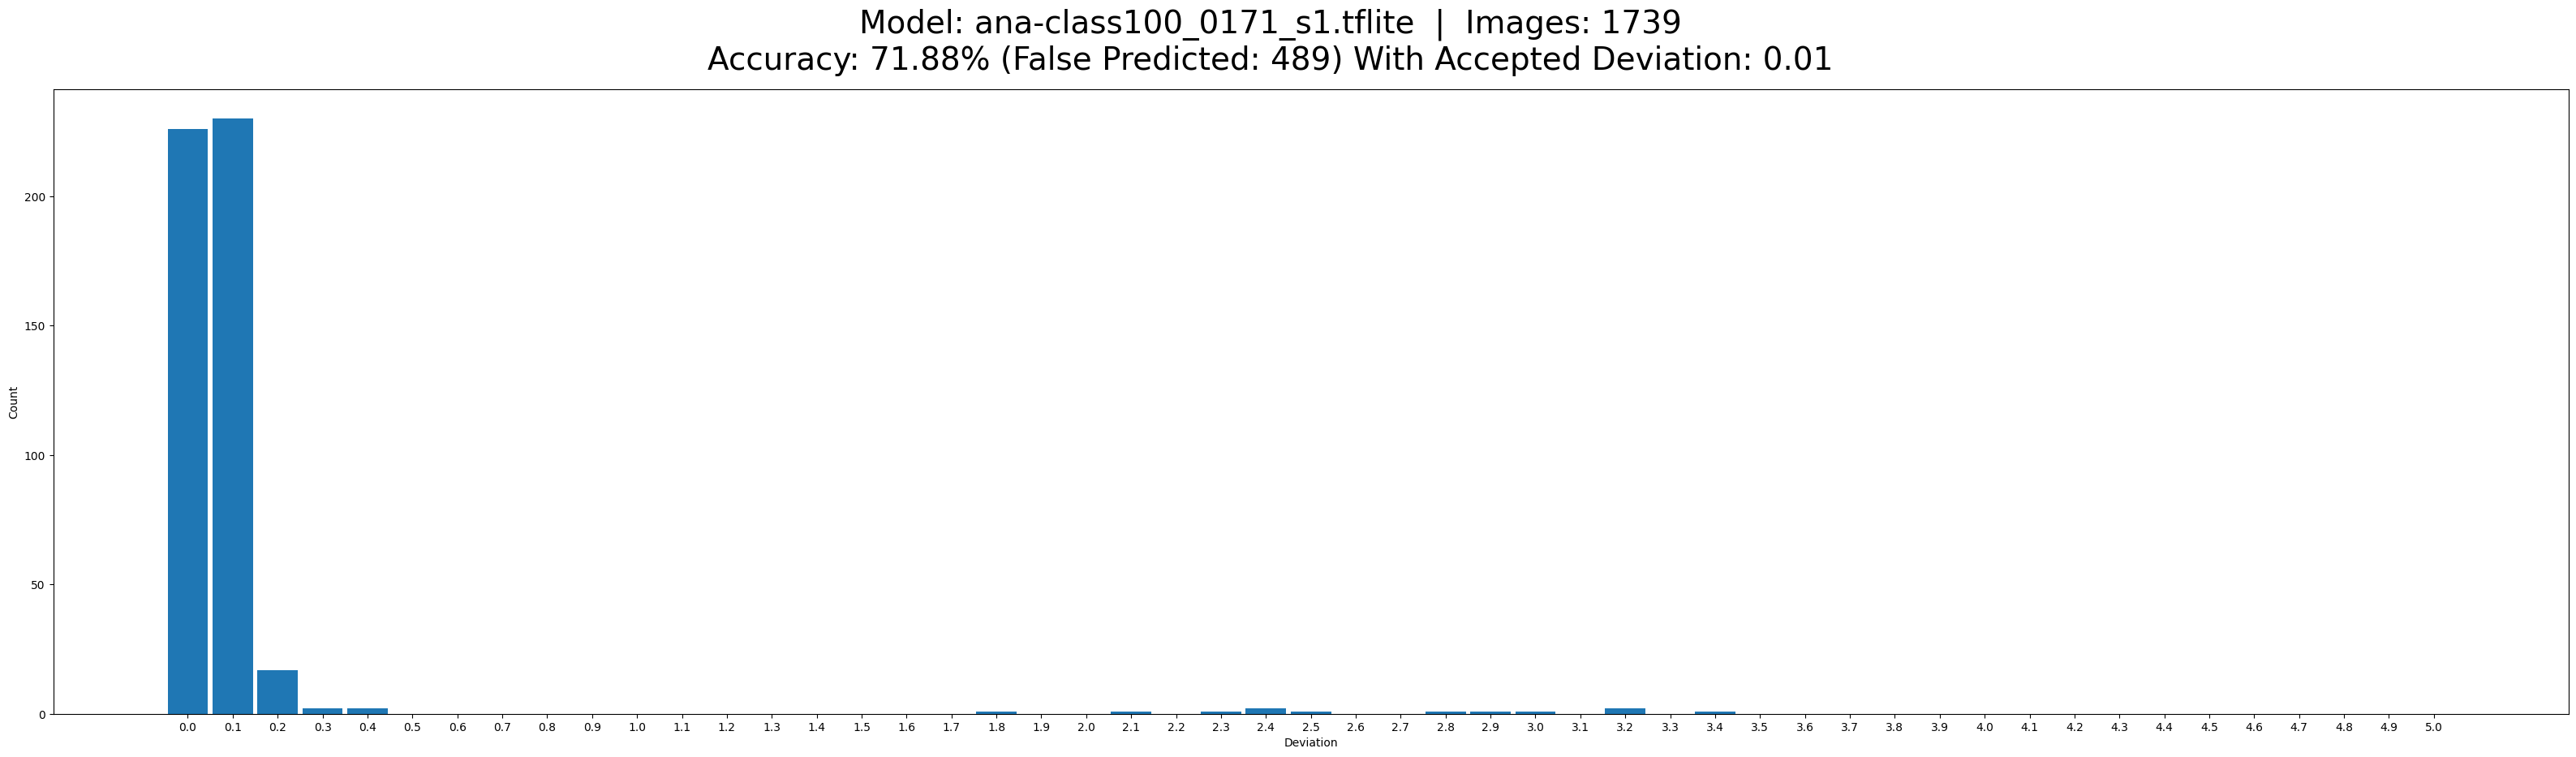

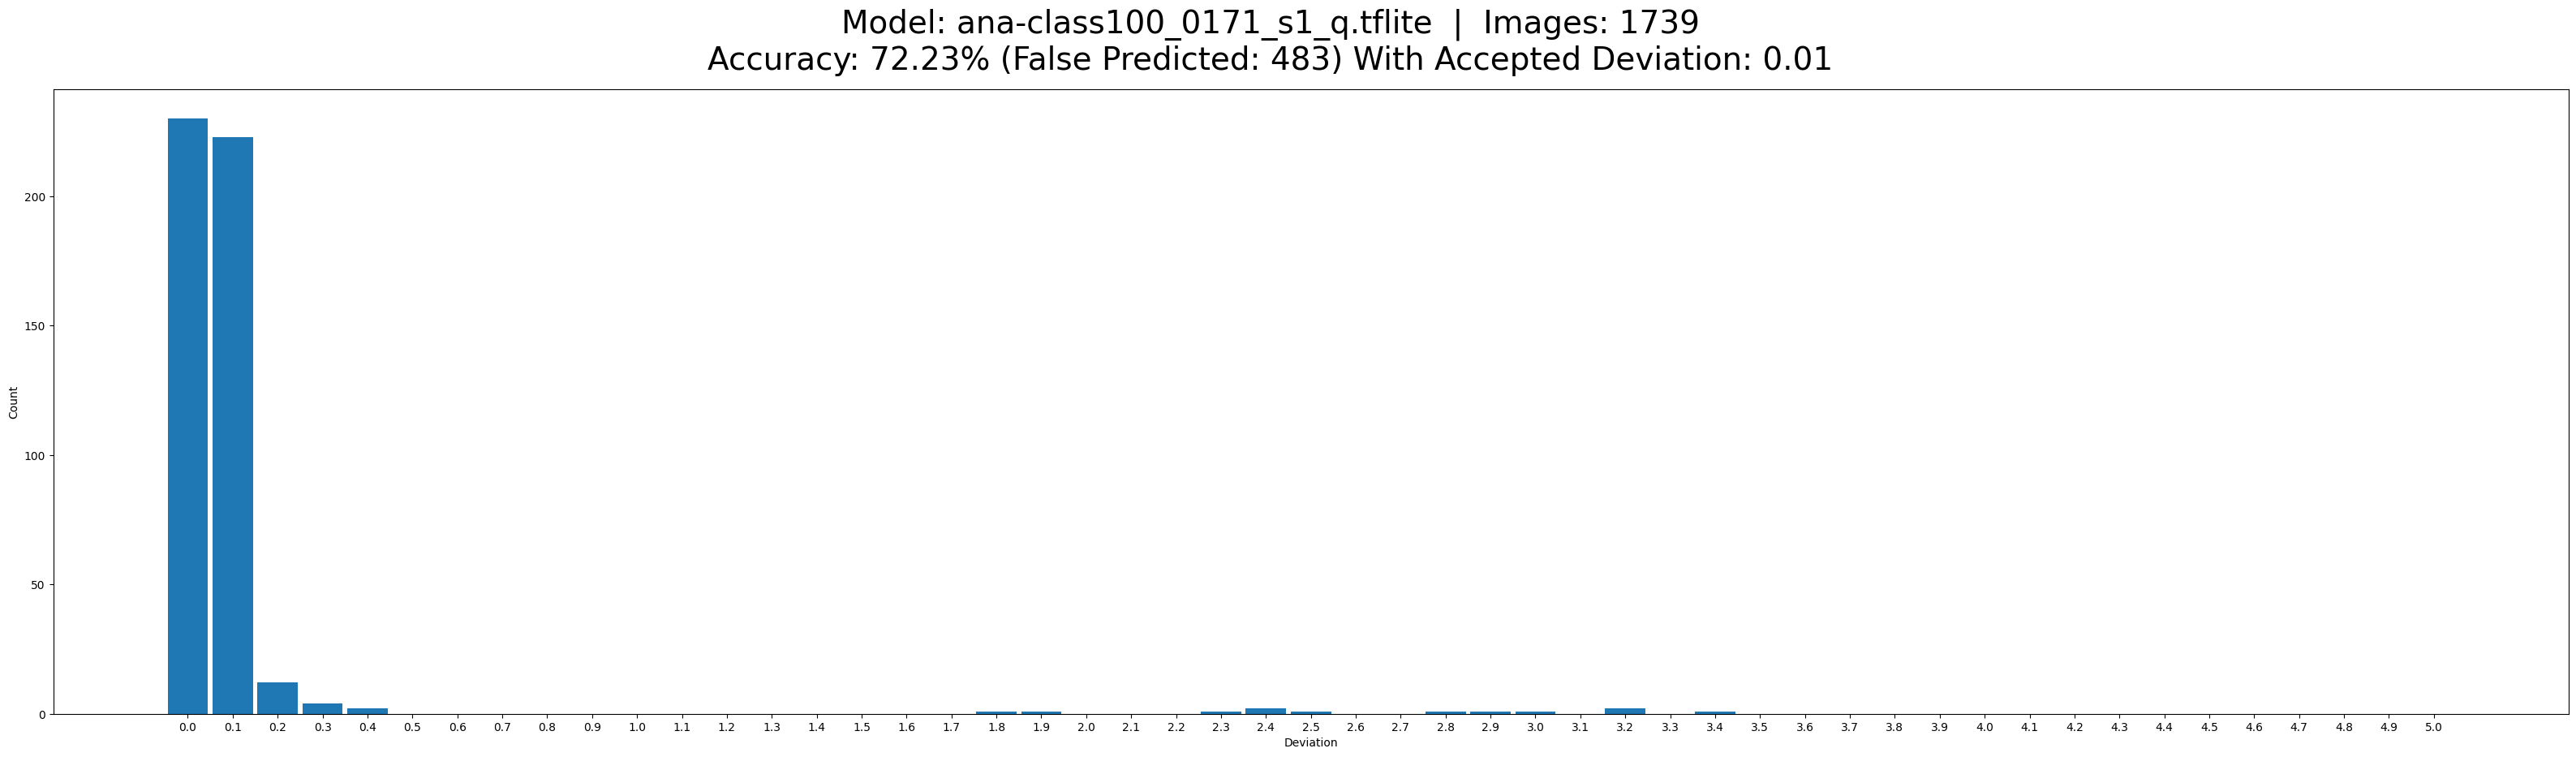

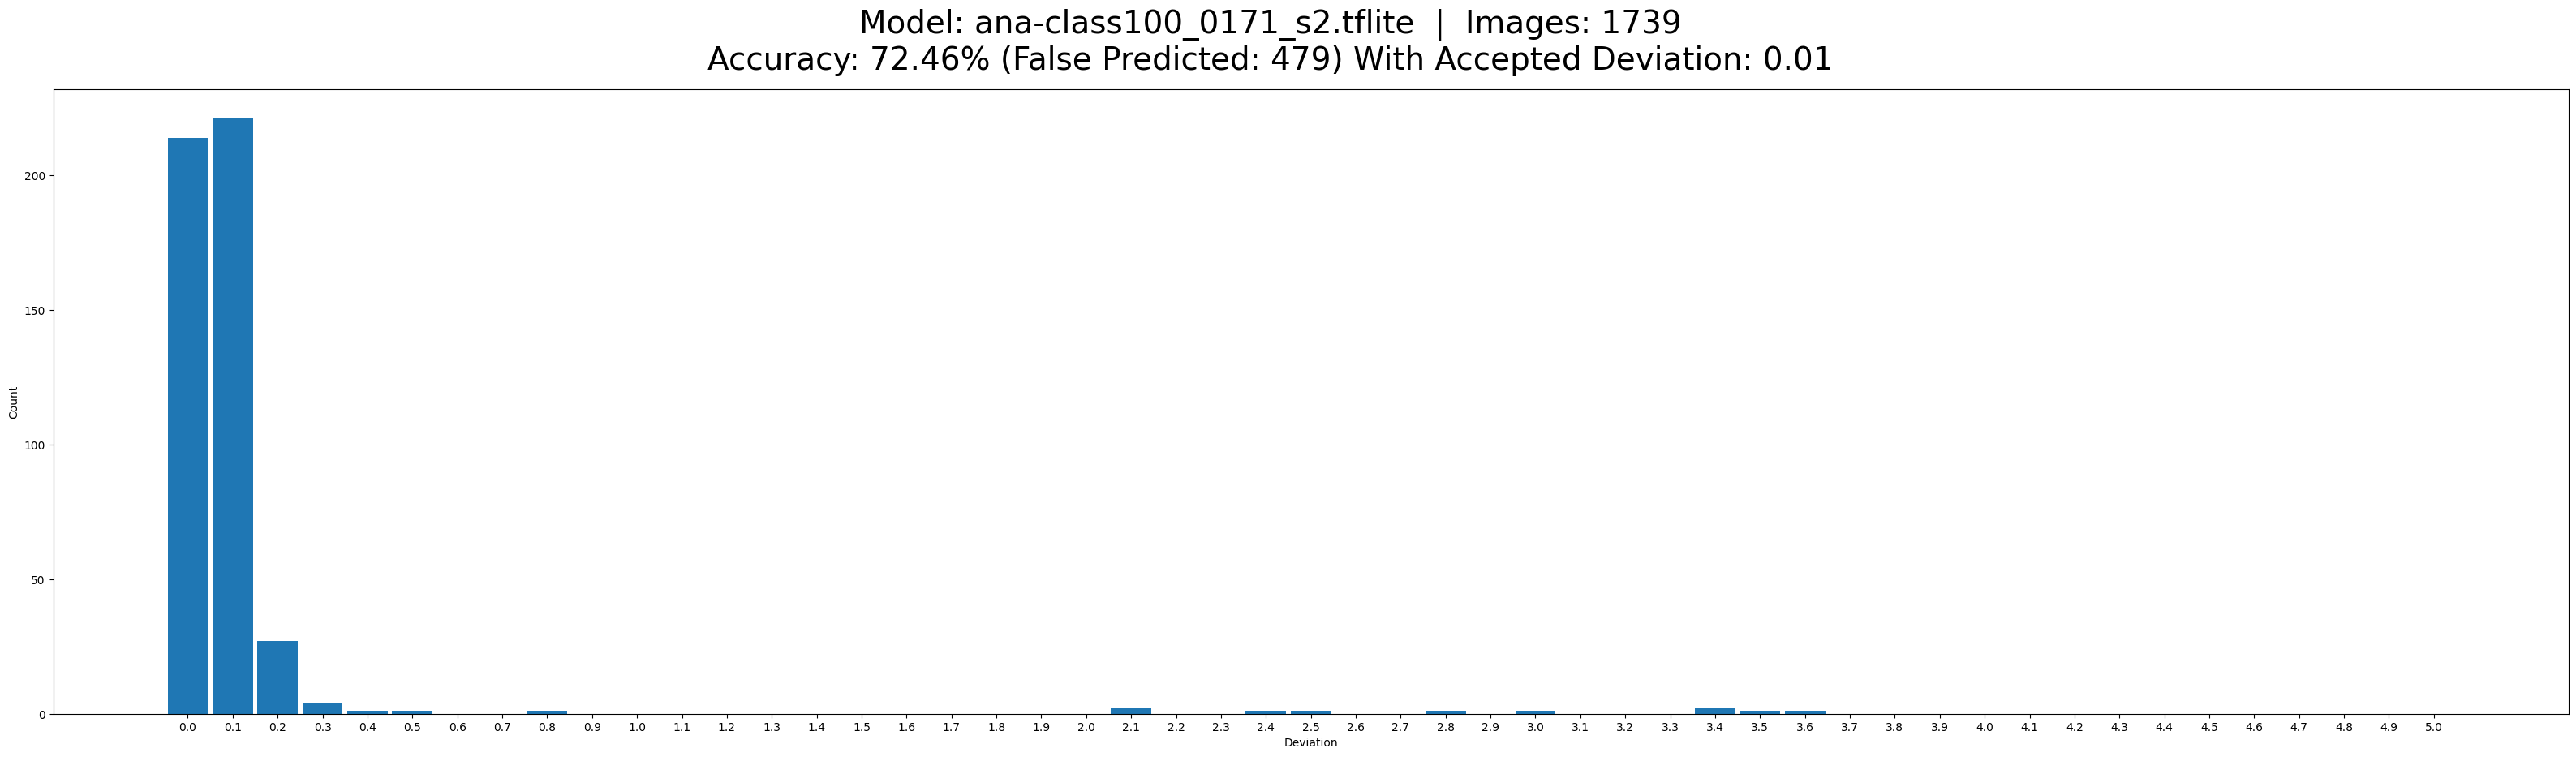

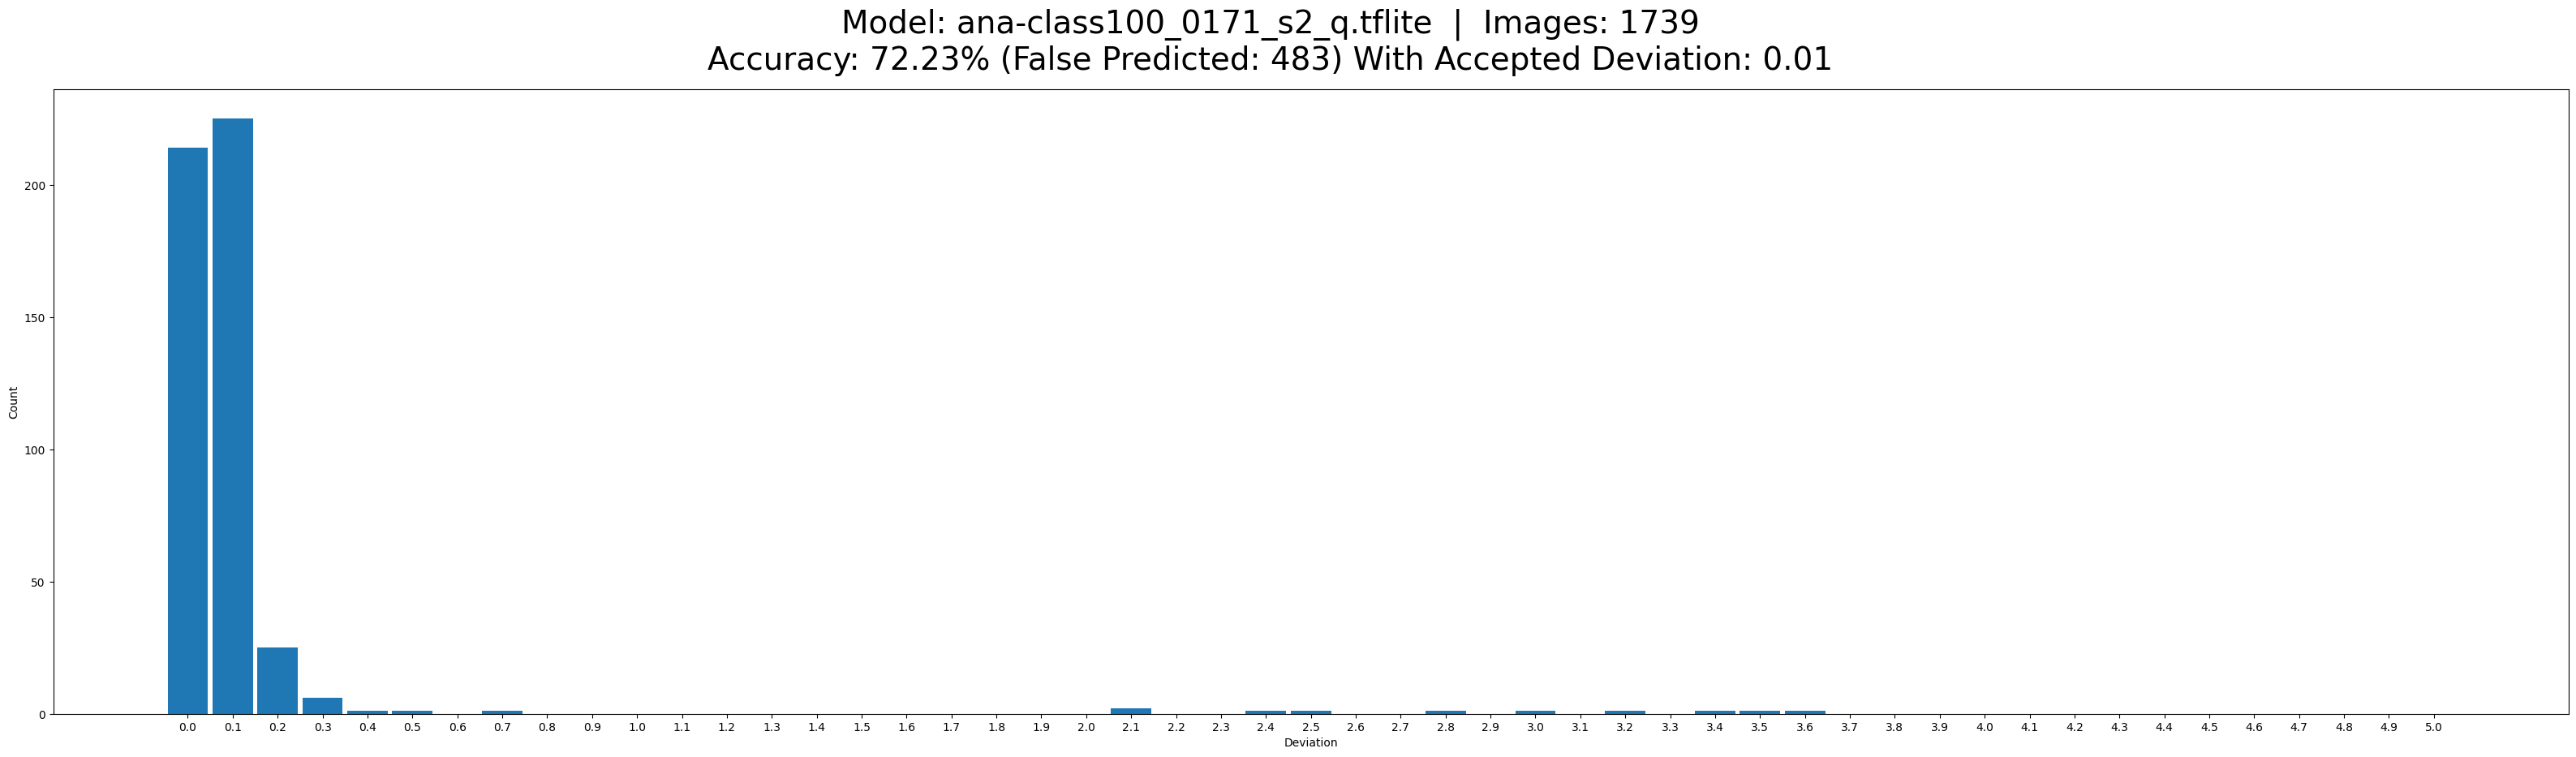

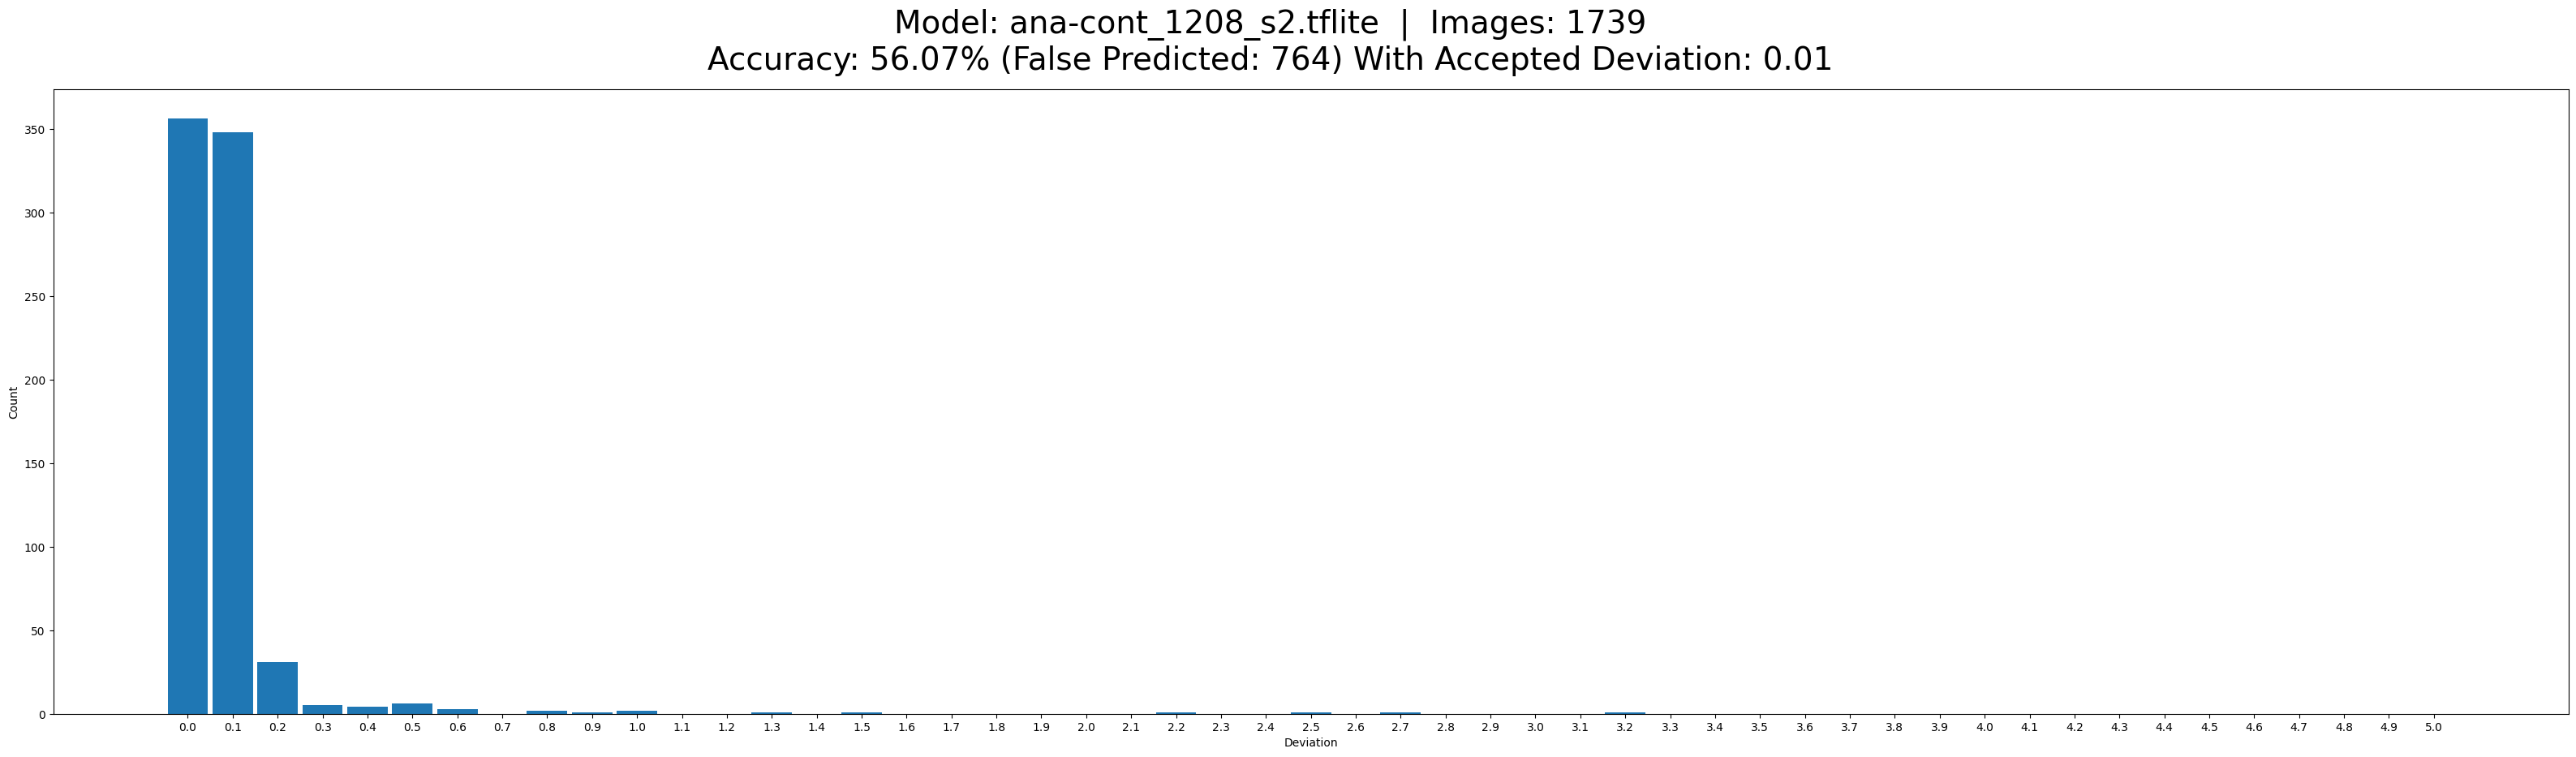

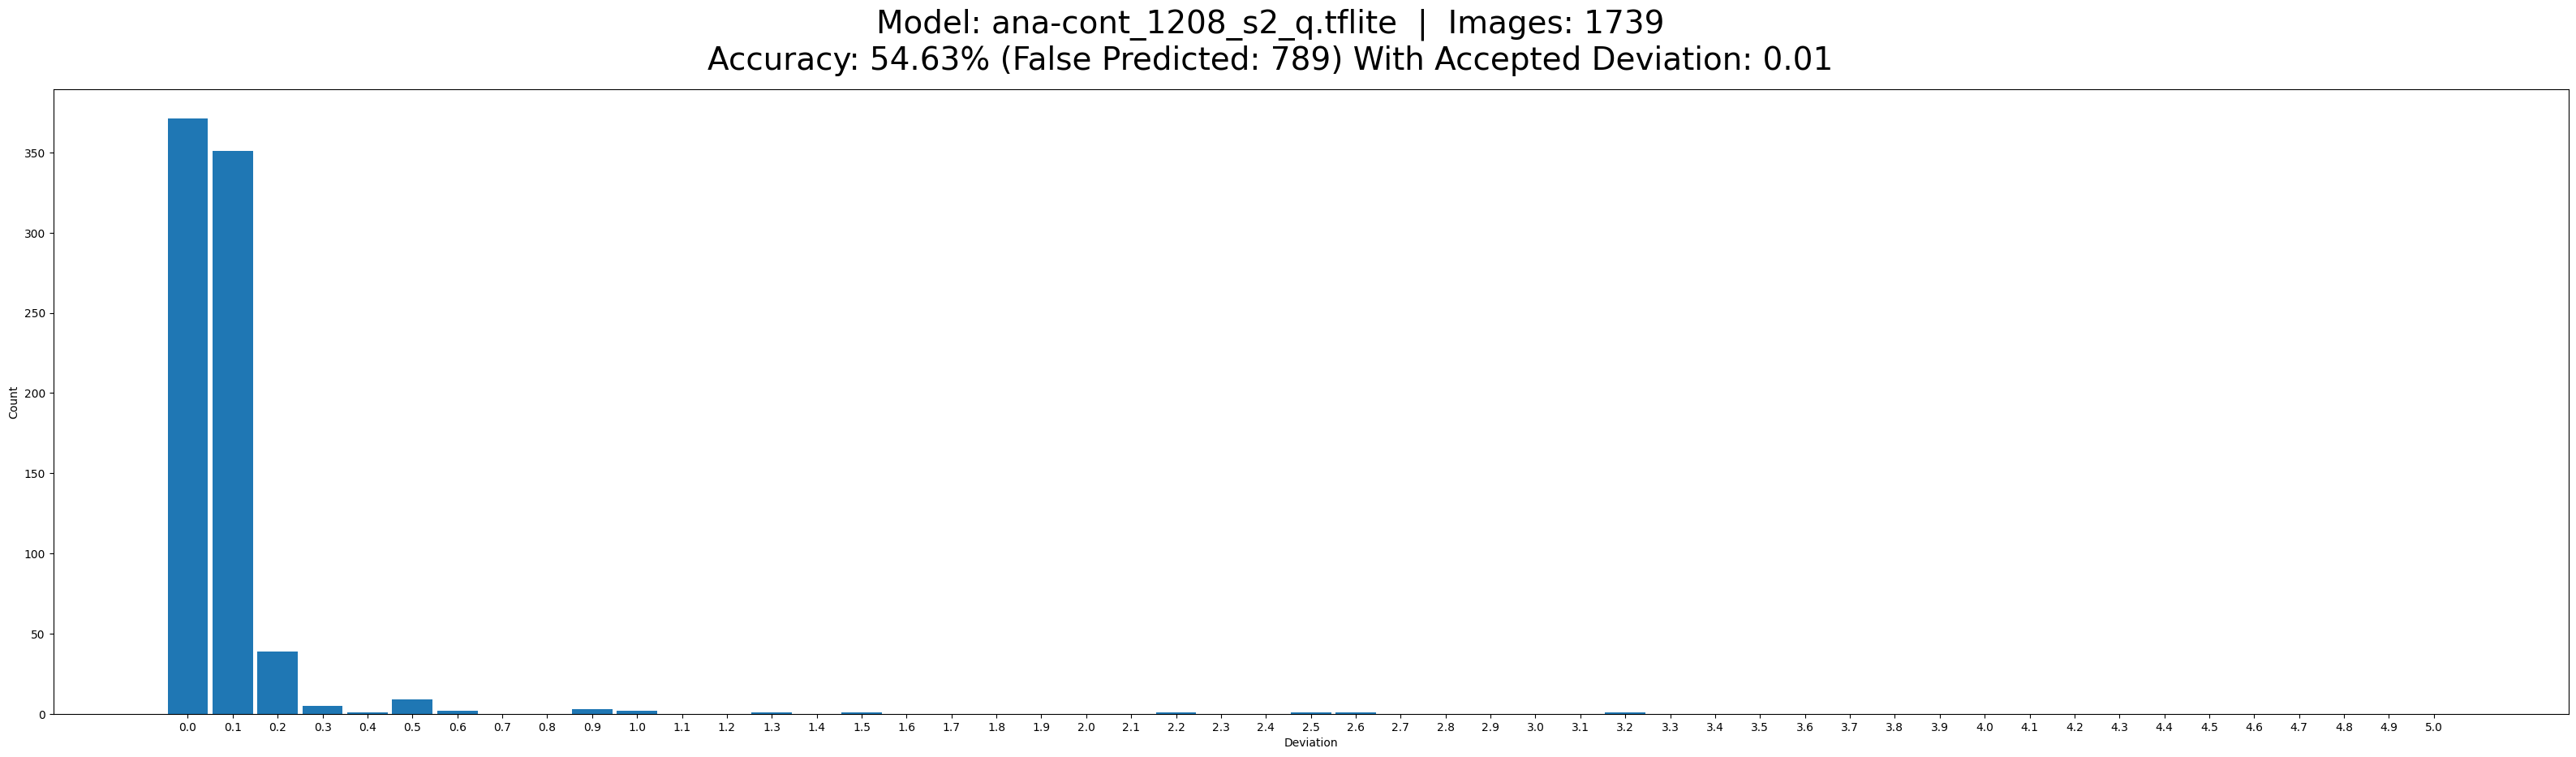

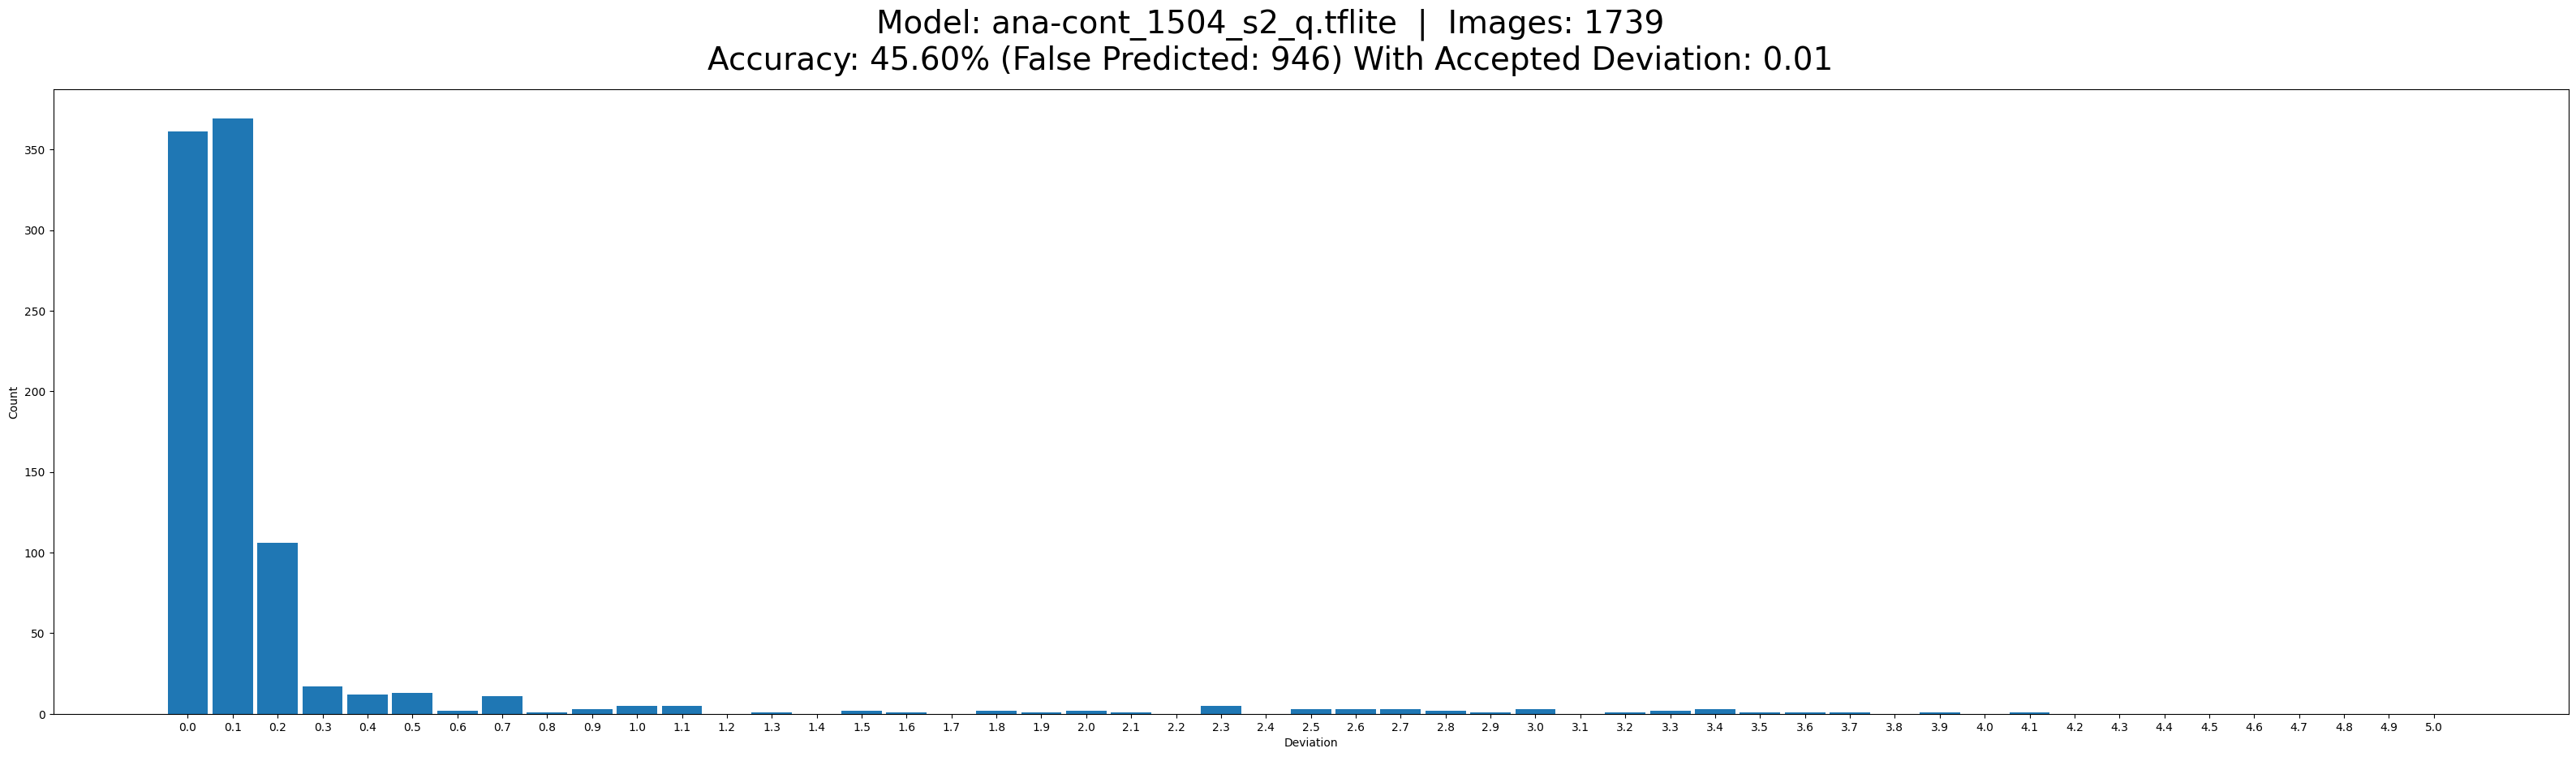

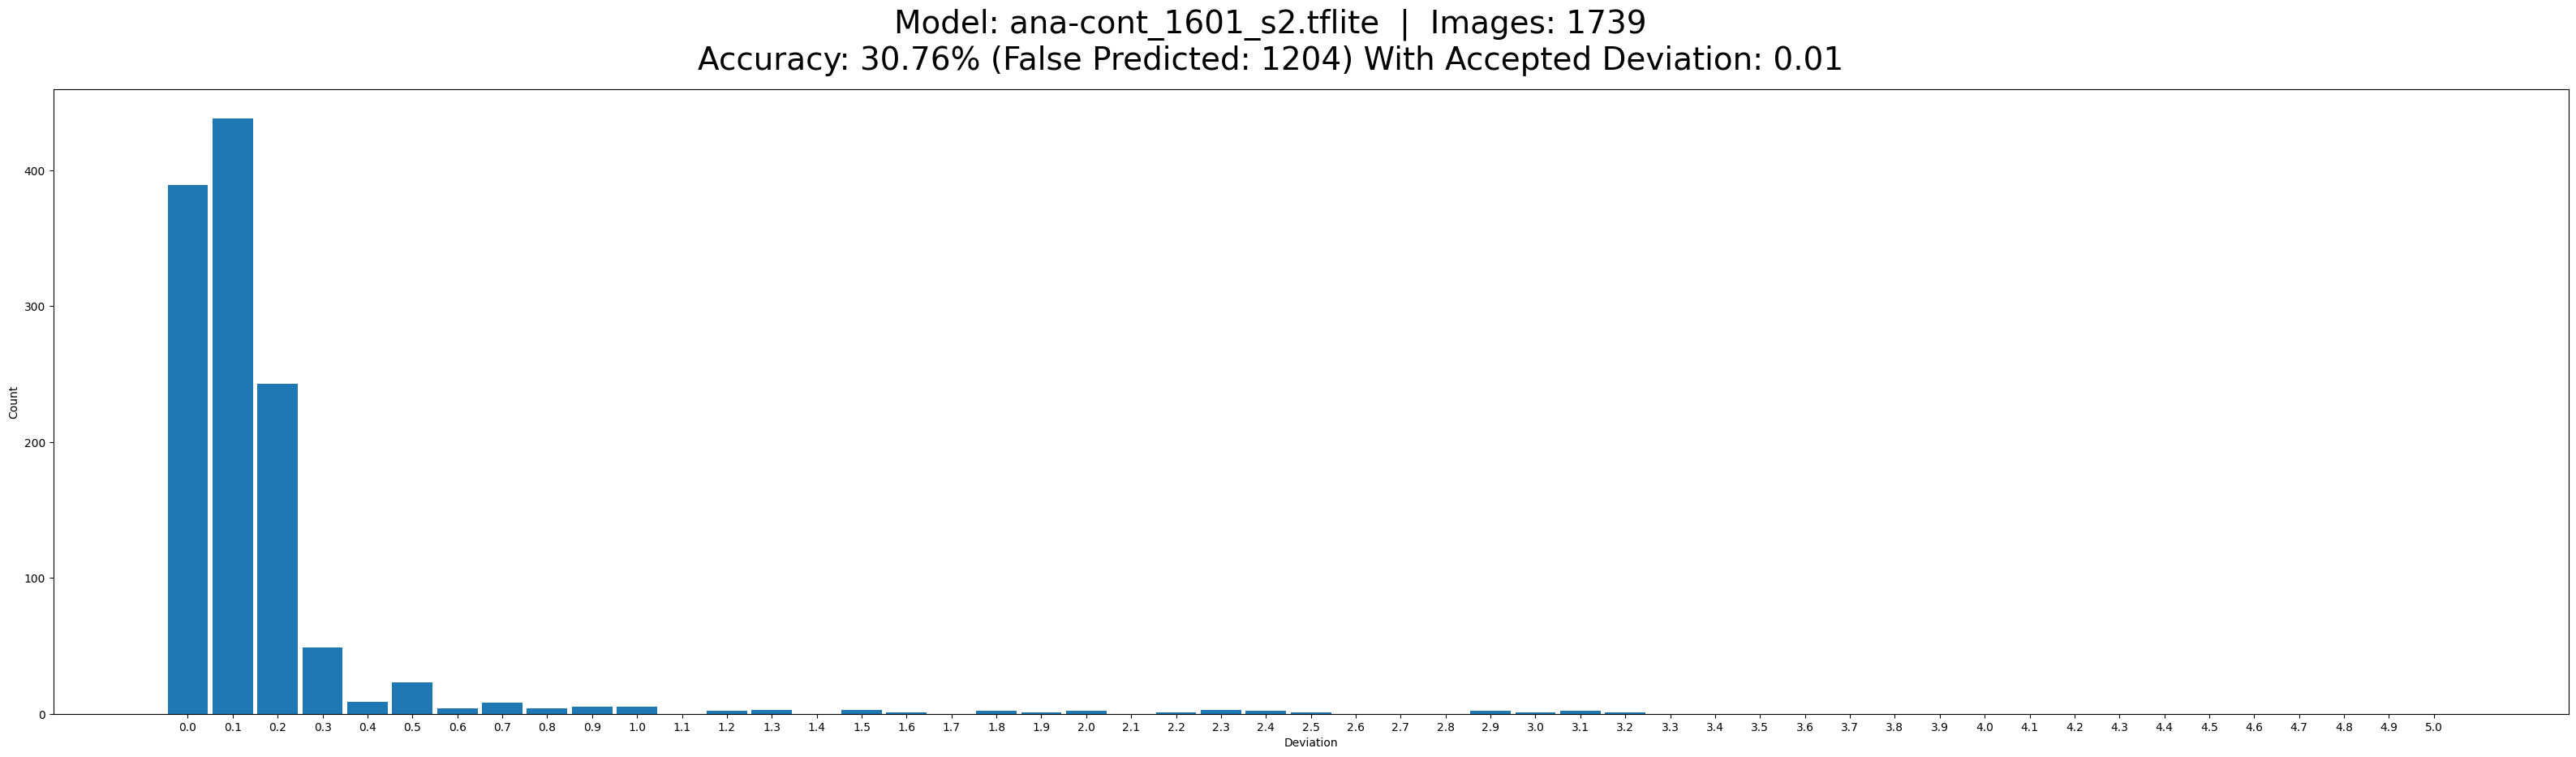

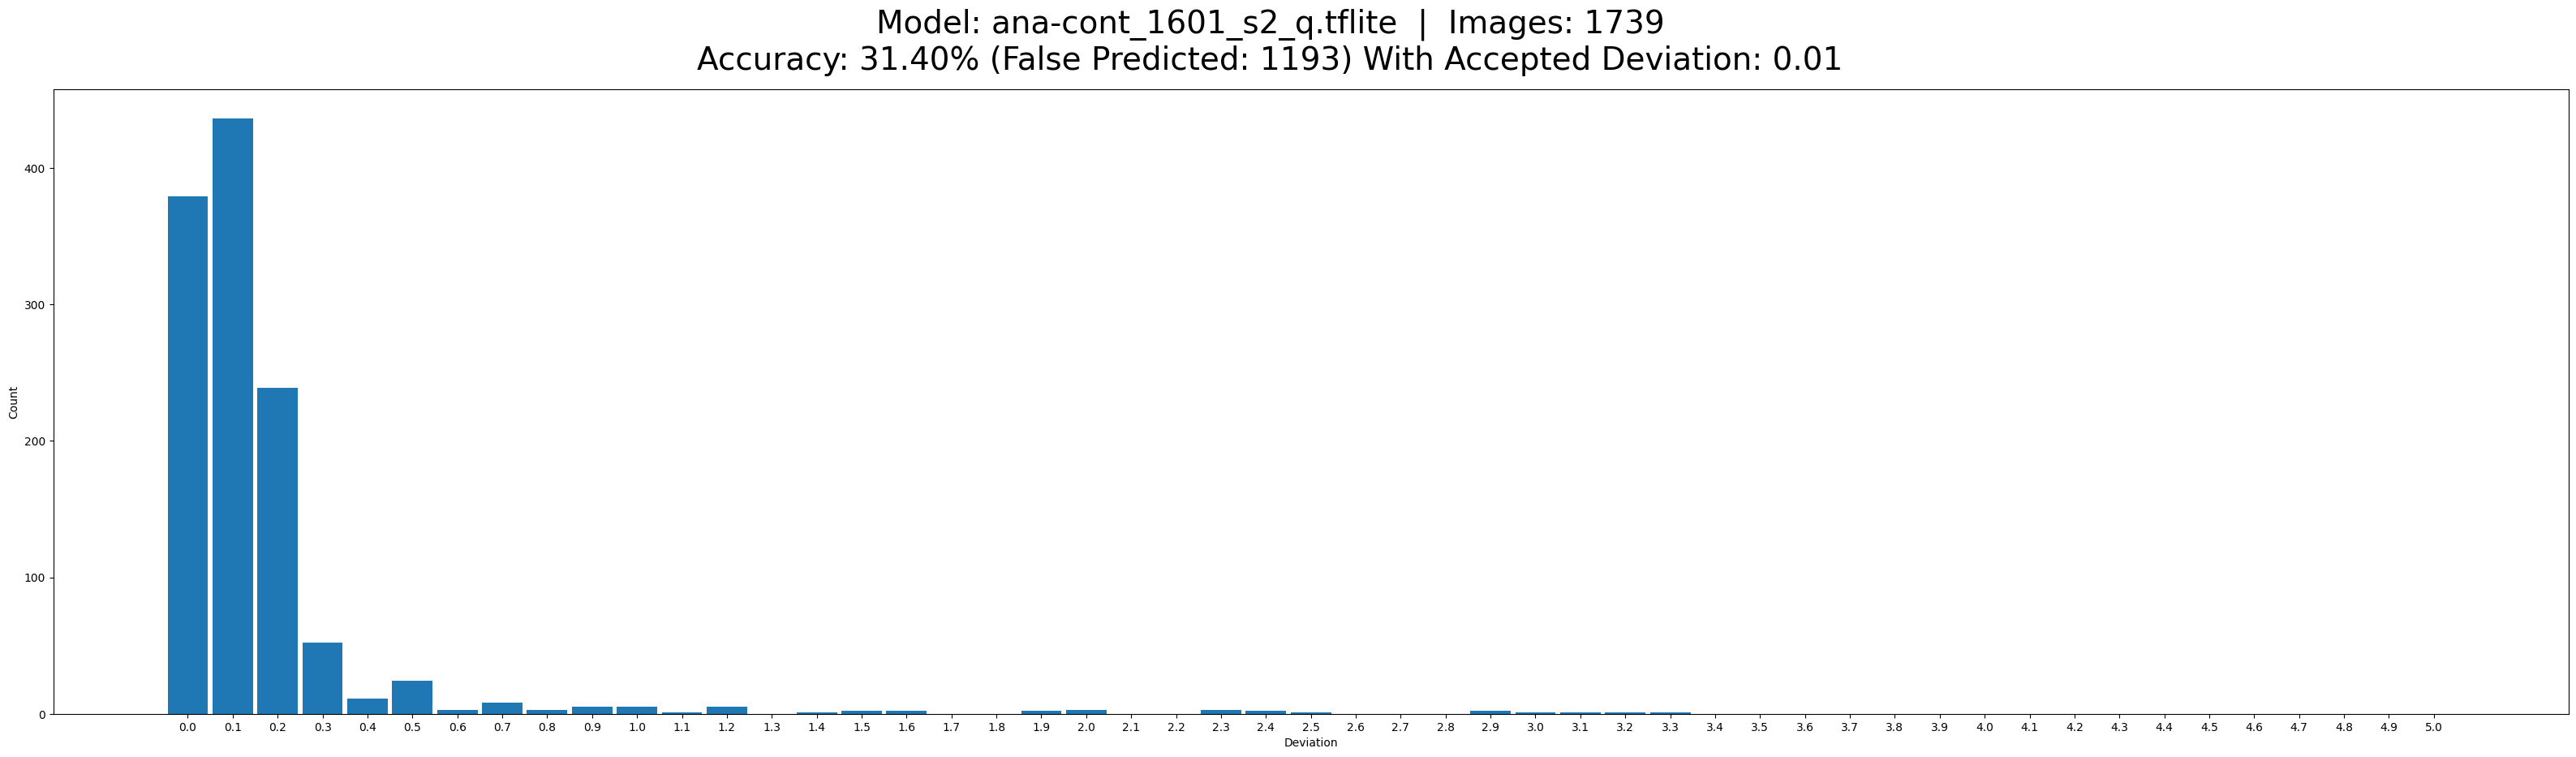

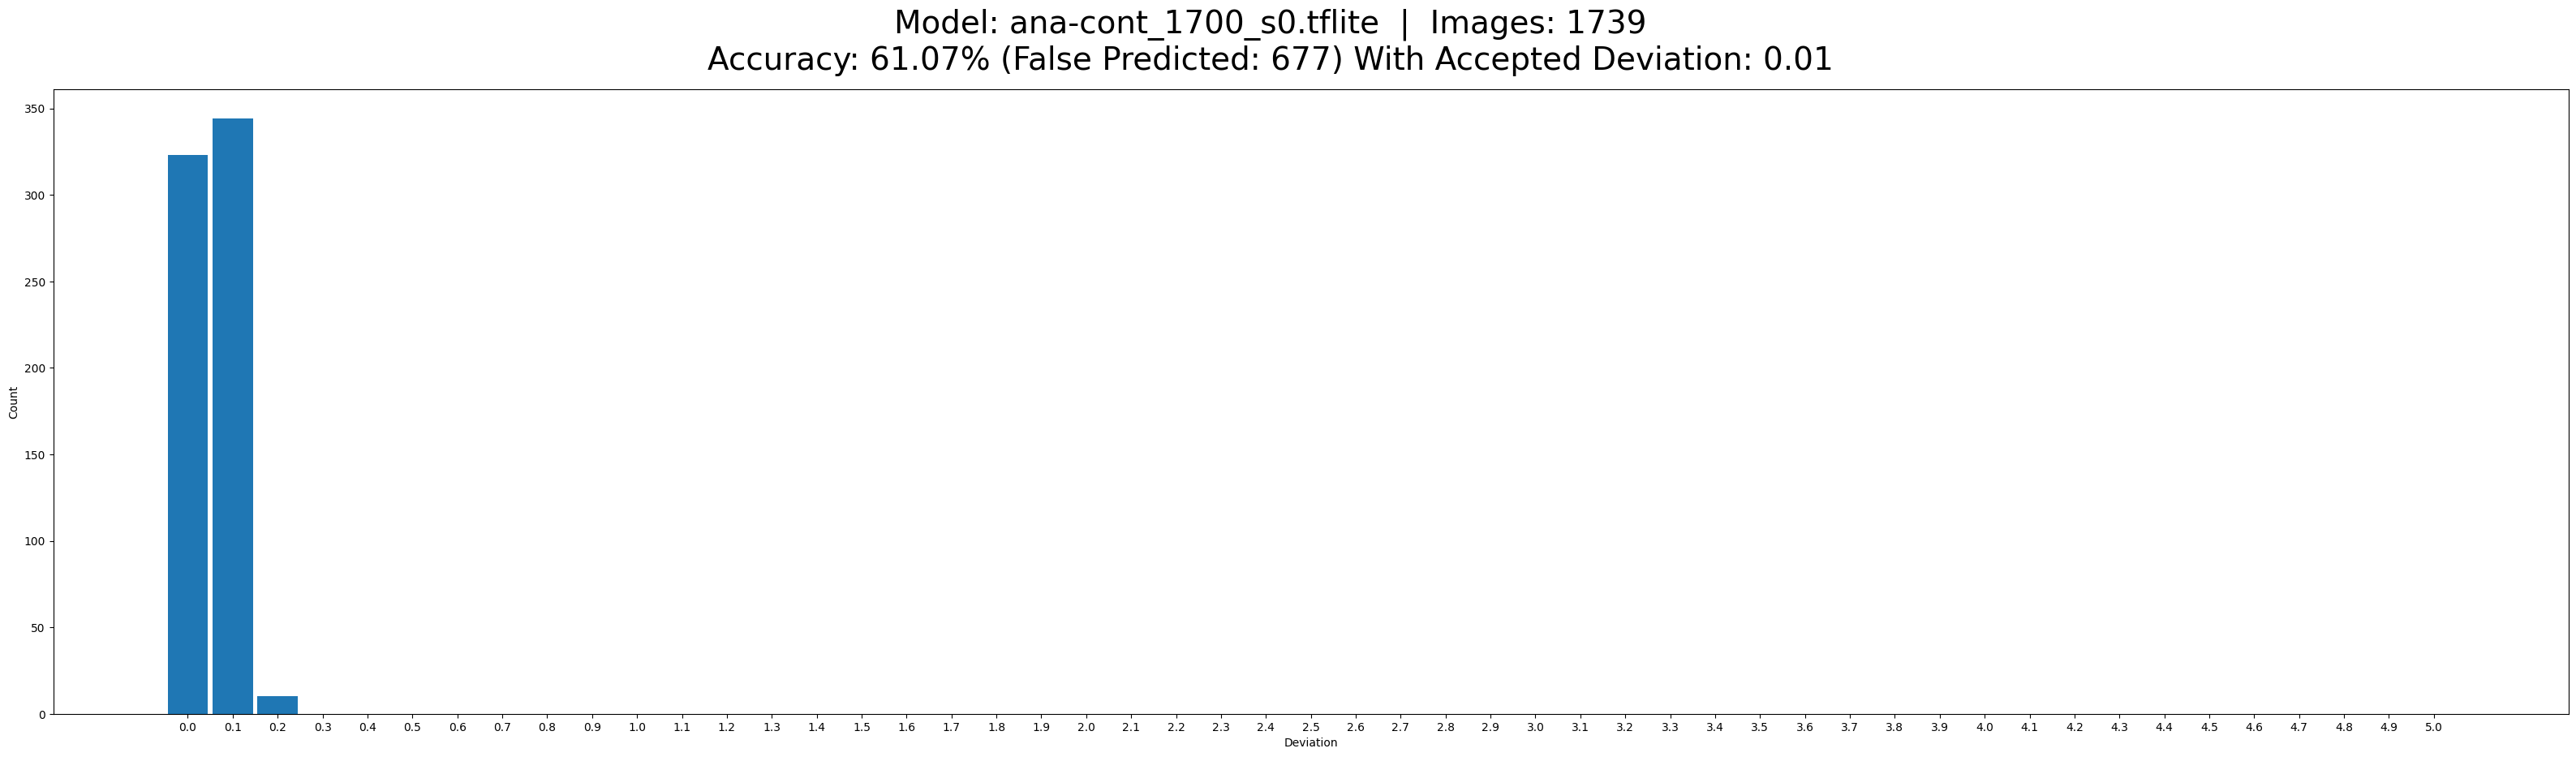

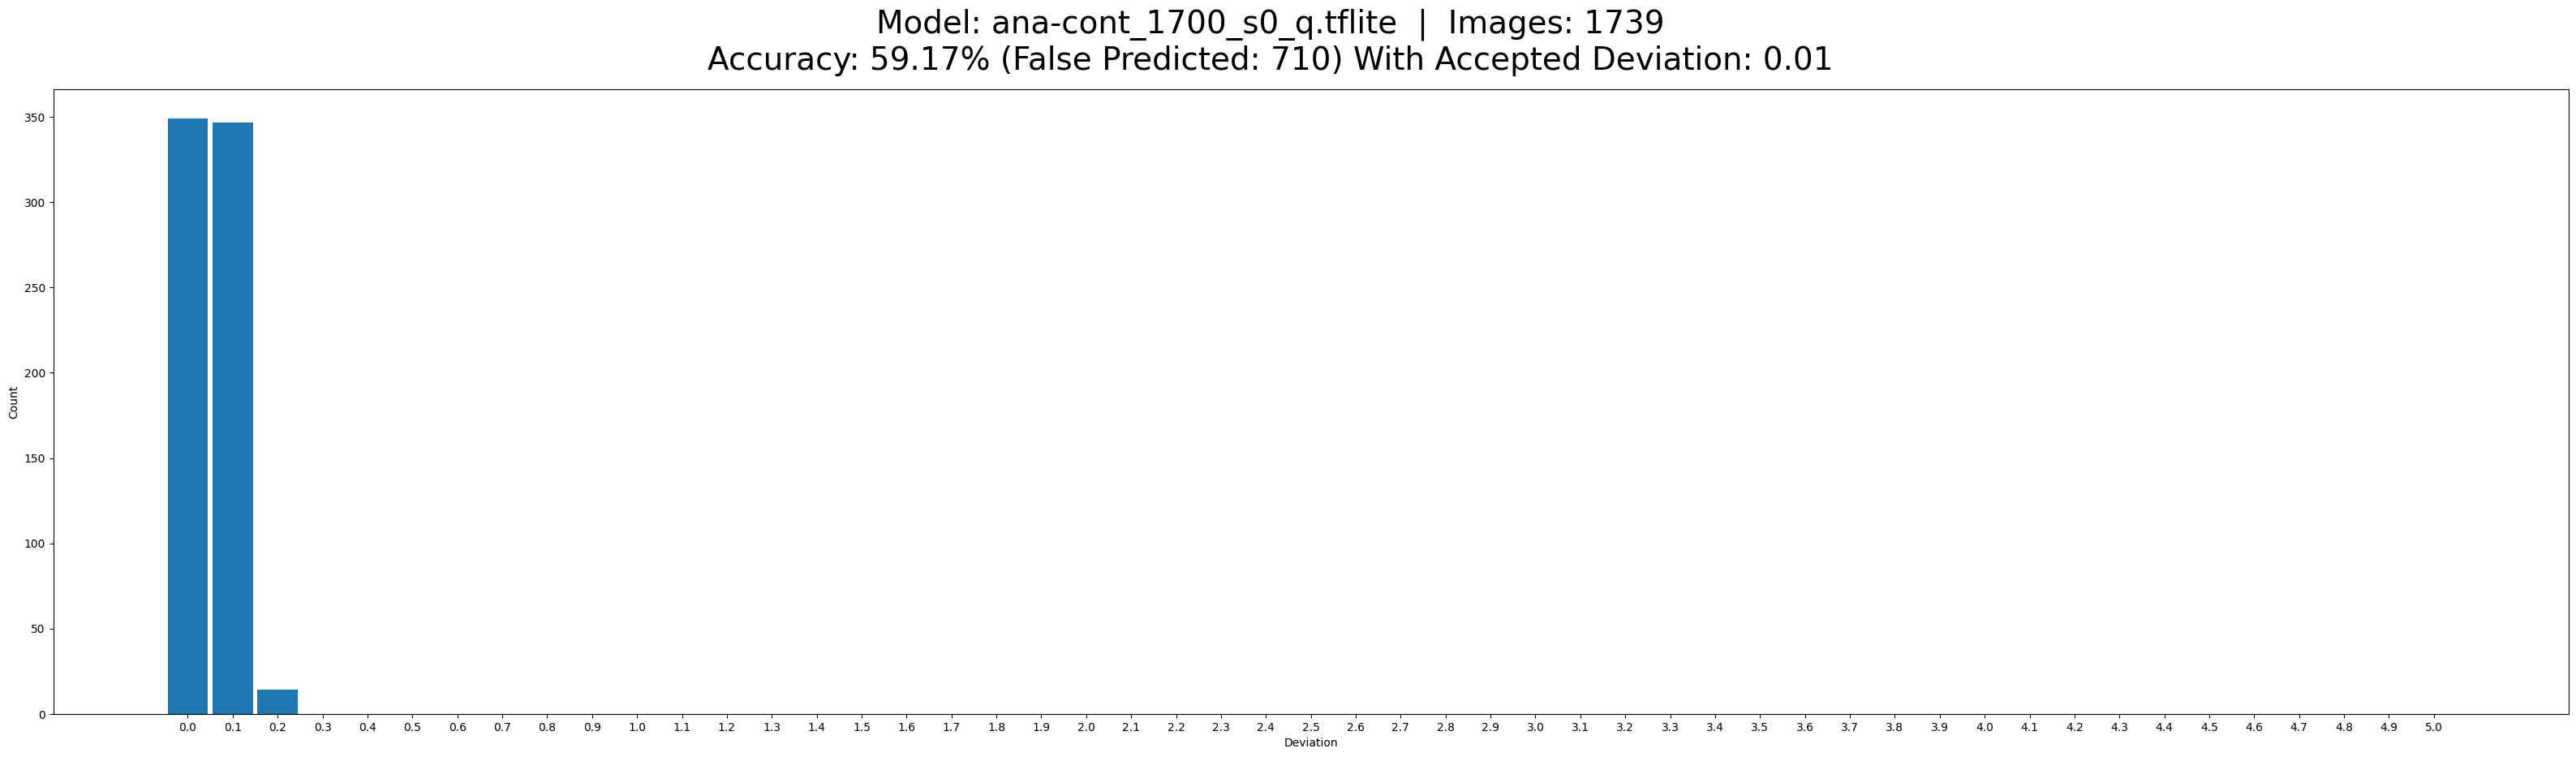

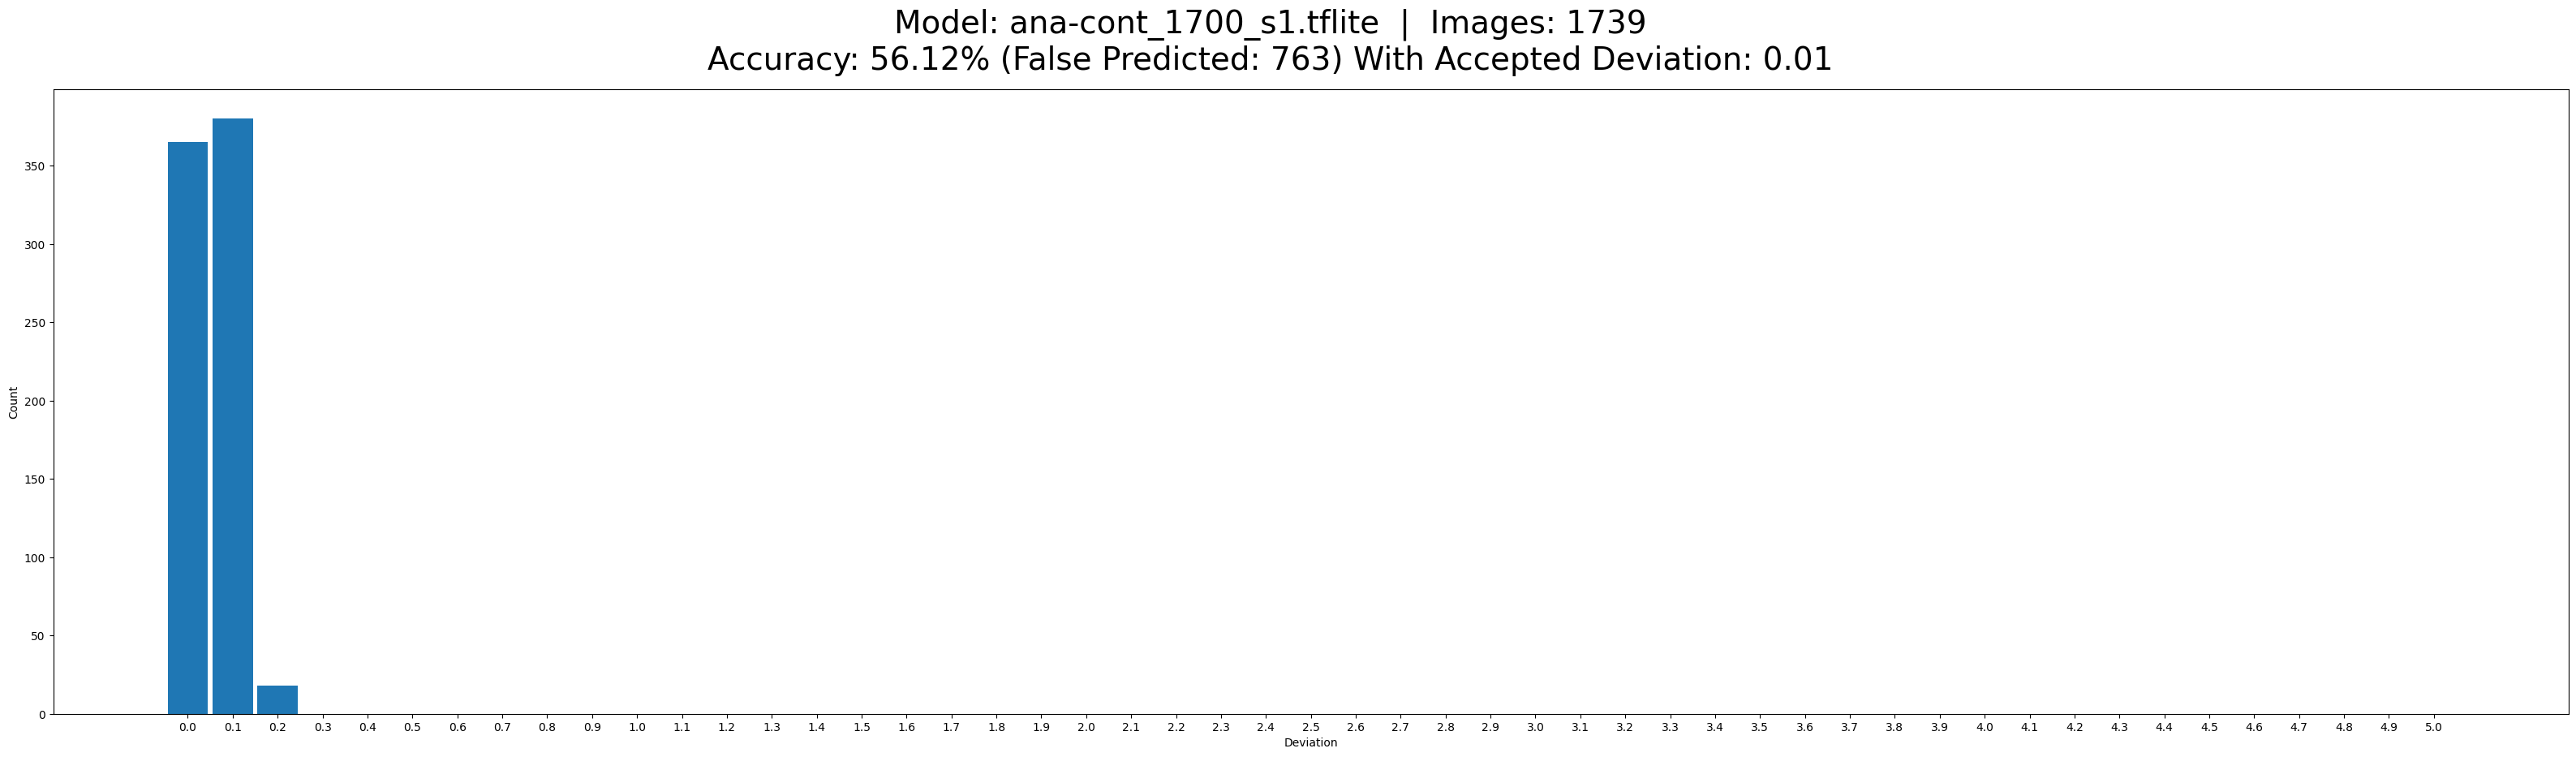

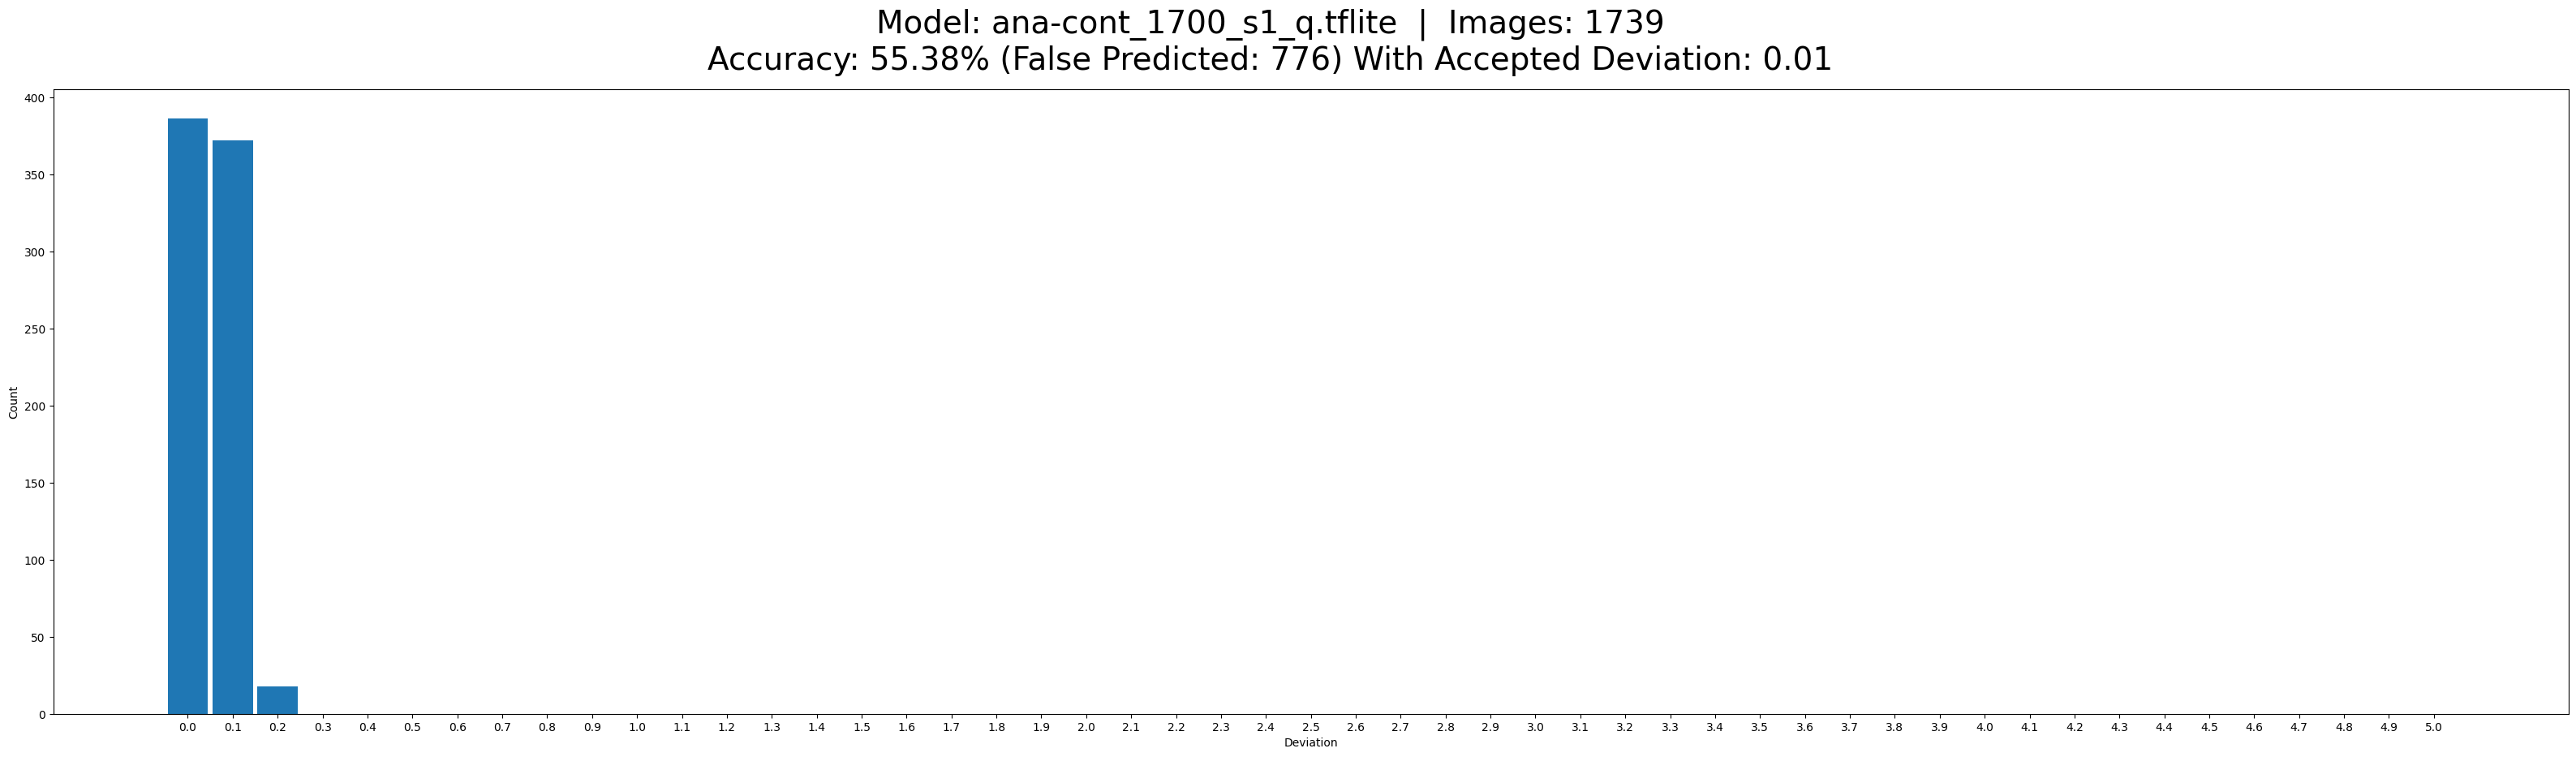

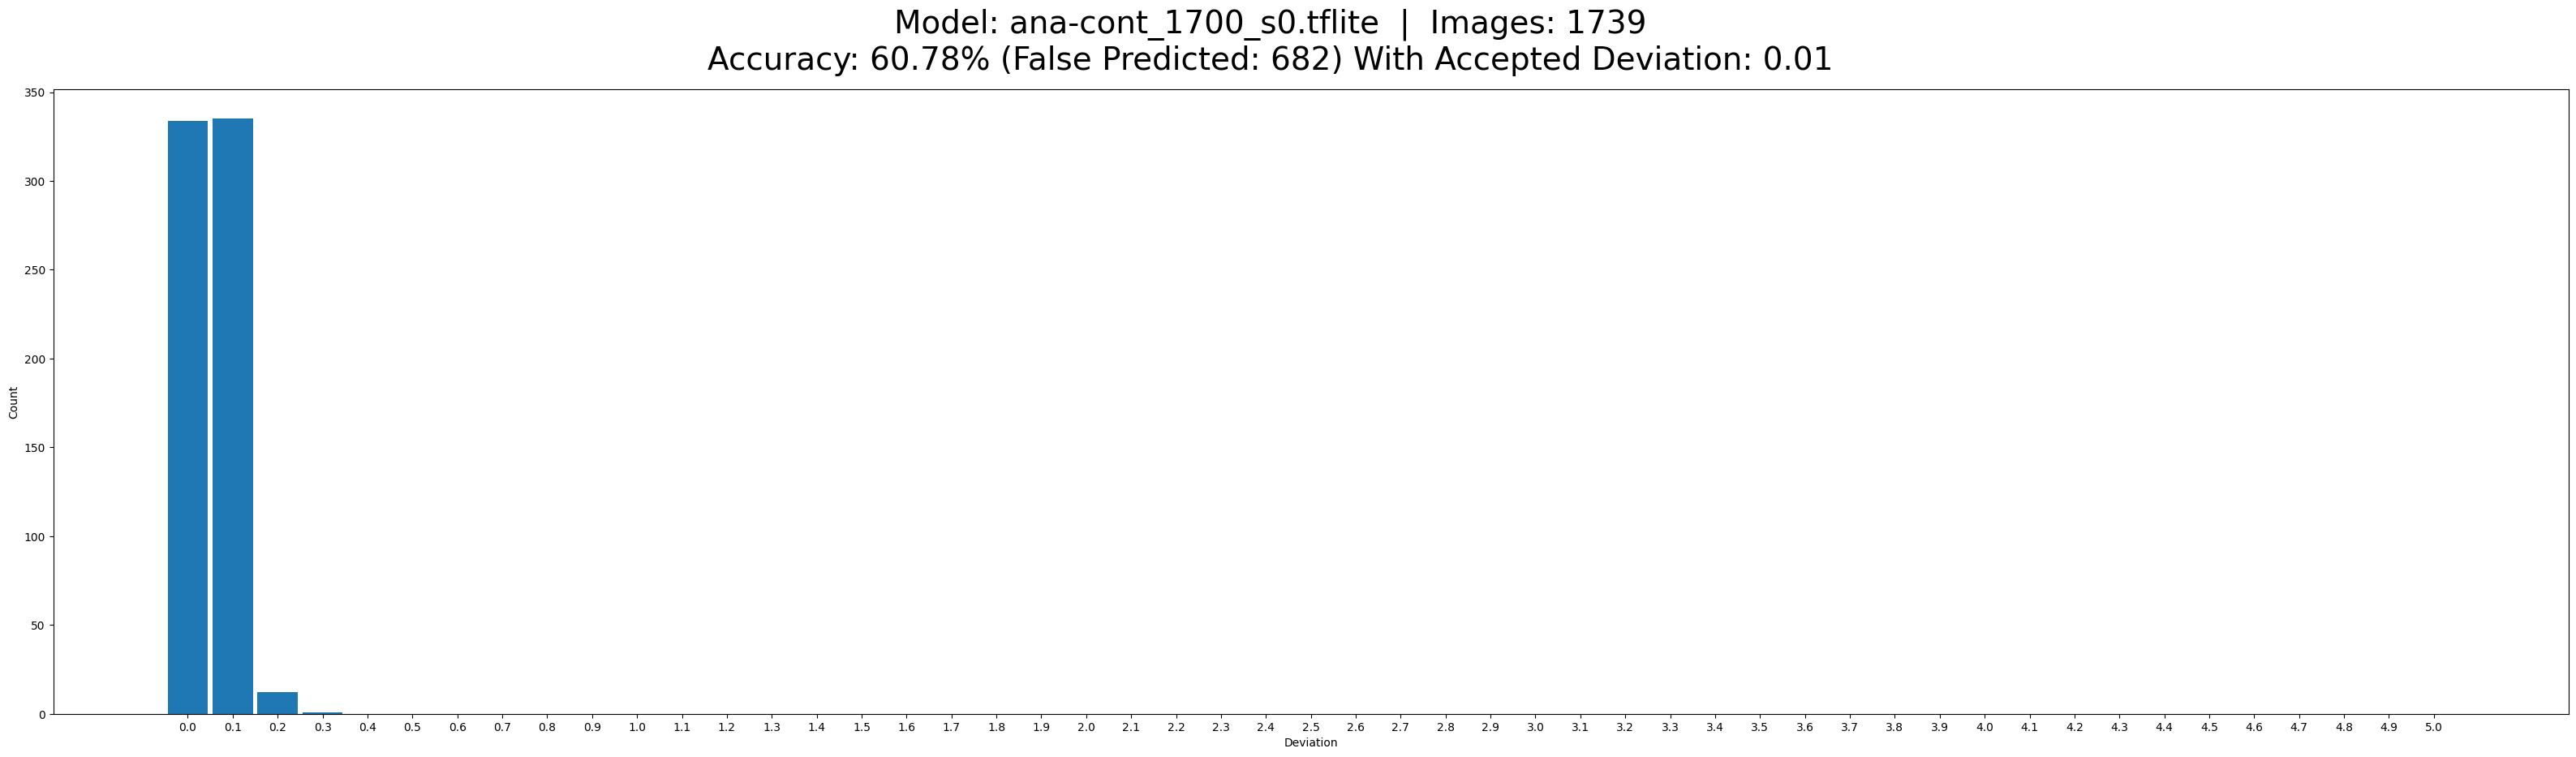

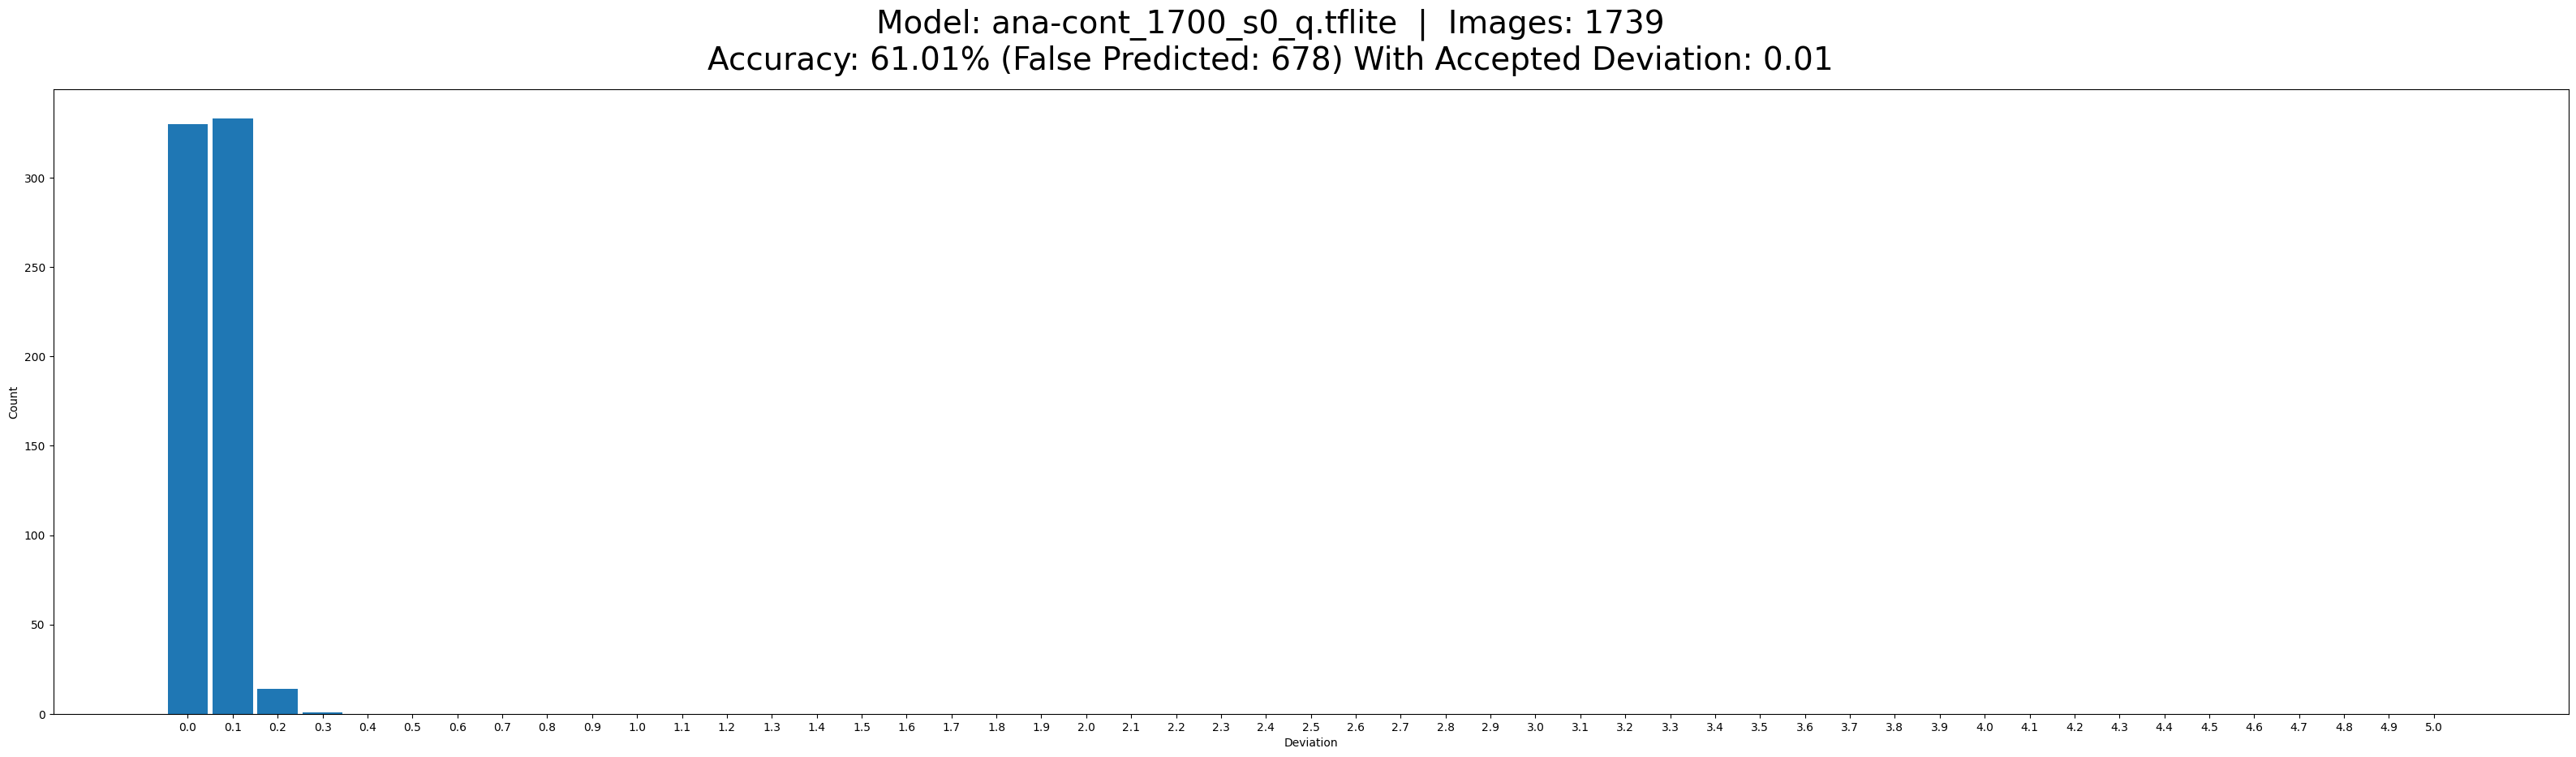

In [7]:
for modelfile in modelfiles:
    evaluate_ziffer_tflite(modelfile, x_data, y_data, f_data, title=modelfile, max_delta=0.01)
    print(f" ")
    print(f" ")